# Data analysis with SciAnalysis

last updated: 2023 June

In this notebook, we can load the raw tiff, load or extract metedata, analysis the data, save the analysis results and metadata in .H5.

--------------------------------------

*exp.dict*: The experiment dictionary. 'Experiment' is a series of measurements, e.g. in-situ thermal annealing measurements of a sample.


--------------------------------------

# &#9635; SciAnalysis for Experiment

At home insitute, download SciAnalysis at: https://github.com/CFN-softbio/SciAnalysis



In [1]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime, pprint, math
import sqlite3
import pandas as pd
from silx.io.dictdump import dicttoh5, h5todict

SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols
from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools

now = datetime.datetime.now()
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
print("{}\n".format(dt_string))

%pwd

2023/07/12 11:15:56



'/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3'

&#9733; __NOTE__

For routine analysis, go to __Section 0__ for calibration and then jump to (__Section 7__ for stitching if needed) __Section 6__ for batch processing 

For real-time analysis of series data, go through other sections.

## 0. Calibration

#### __Direct beam__

['/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3/saxs/raw/AgBH_cali_2m_13.5kev_directbeam_x0.000_th0.000_1.00s_1135305_saxs.tiff']
Size = (1679, 1475)
Beam center = [757, 1078]
Beam center = [758, 1078]


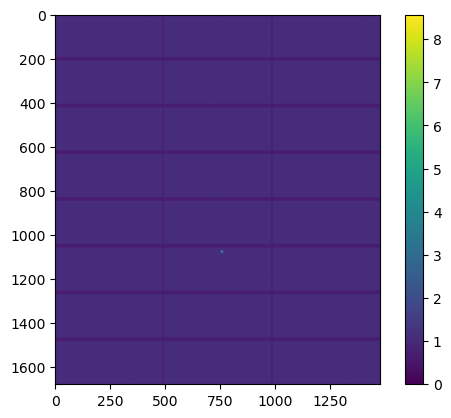

In [5]:
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3/saxs/'
pattern = '*directbeam*'
infiles = glob.glob(os.path.join(EXPR_DIR+'raw/', pattern+'.tiff'))

#infiles = sorted(infiles, key=lambda x: x.split('_saxs')[0].split('_')[-1]) 
print(infiles)

if len(infiles)>0:
    data = Data2DScattering()
    data.load(infiles[-1])
    #data.blur(sigma=1)
    img = data.data
    print('Size = {}'.format(img.shape))

    ## Plot
    %matplotlib inline
    plt.figure(1); plt.imshow(np.log(img+3)); plt.colorbar()
    beam_center = [np.argmax(np.max(img,0)), np.argmax(np.max(img,1))]
    print('Beam center = {}'.format(beam_center))

    img[beam_center[1], beam_center[0]] = 0
    beam_center = [np.argmax(np.max(img,0)), np.argmax(np.max(img,1))]
    print('Beam center = {}'.format(beam_center))
else:
    print('No matching files found')

#### __&#9733; Calibration AgBH__

Energy, beam center, SD distance

1. Specify wavelength 
2. Tweak beam center and SD distance to get the best match for the calibrant
3. __For SAXS, make custom mask (in GIMP) to cover up beamstop__

/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3/saxs/raw/
Loading 2 files
Loaded 2 files.
(defFiles time = 0.0s)
/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//saxs/analysis/calibration_check/

Calibration qlist = [0.     0.1076 0.2152 0.3228]

fit_param = [height, width, prominence]
10 peaks found: [0.0484 0.0598 0.1652 0.1748 0.1764 0.1785 0.1794 0.1813 0.1822 0.1834] for fit_prom 0.03235
fit_param = [height, width, prominence]
10 peaks found: [-0.1673 -0.1666 -0.1491 -0.0037  0.0033  0.1058  0.154   0.1552  0.158
  0.1624] for fit_prom 0.07463


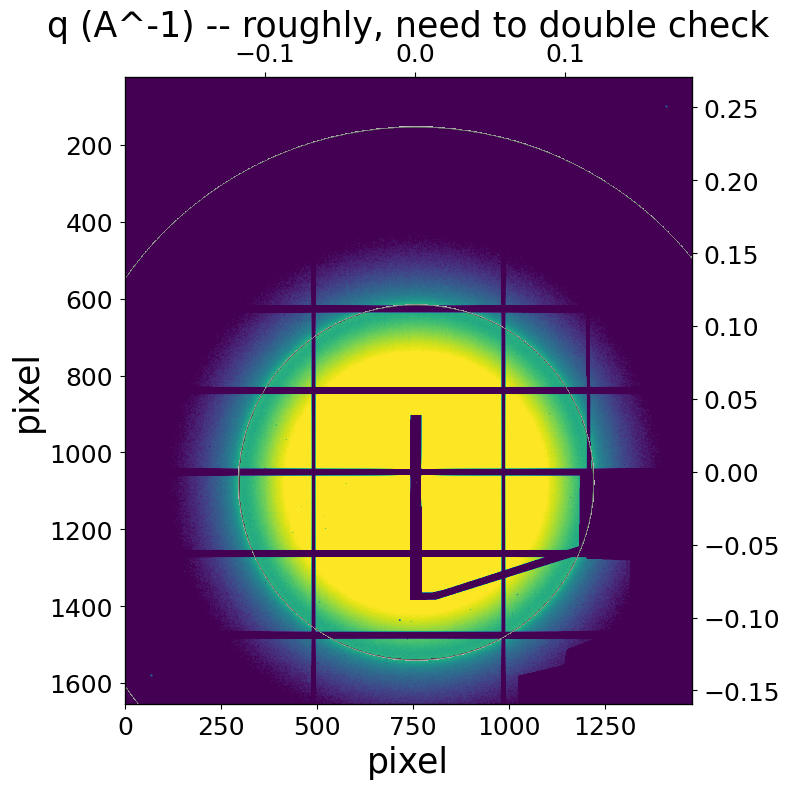

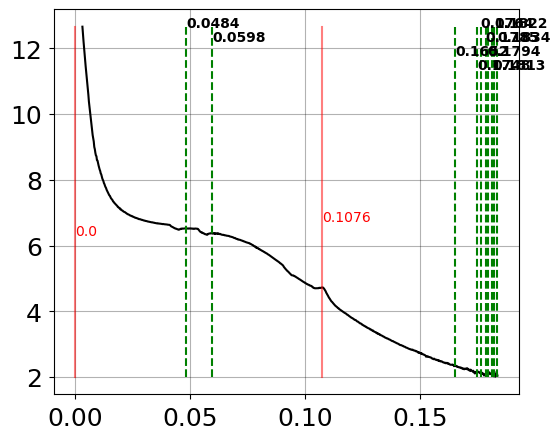

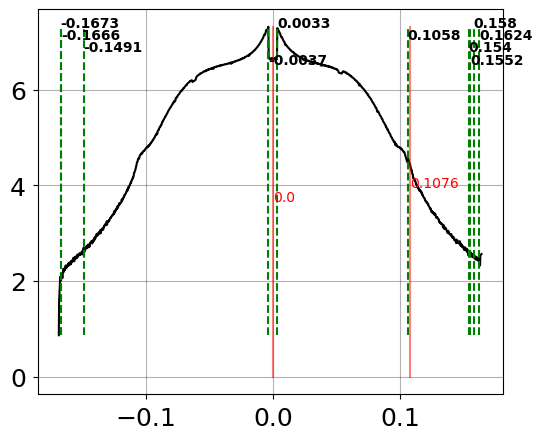

In [21]:
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3/'
exp = Experiment.experiment('Ag', folder=EXPR_DIR, det='saxs', beamline='None') ##Experiment name: rbitrary or related to the sample name
pattern = 'Ag*10.00*'          
        
load_custom_mask = 1
custom_mask = EXPR_DIR+'saxs/analysis/mask_5m_saxs.png'


### Specify beam positions, distance, etc
calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
calibration.set_image_size(1475, height=1679) # Pilatus2M
calibration.set_pixel_size(pixel_size_um=172.0)

calibration.set_beam_position(757, 1679-601) # SAXSx -65, SAXSy -73    
calibration.set_distance(5.05)    

mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
if 1: #flag_stitch
    mask = Mask(mask_dir+'Dectris/Pilatus2M_vertical_gaps-mask.png')
else:
    mask = Mask(mask_dir+'Dectris/Pilatus2M_gaps-mask.png')

if load_custom_mask:
    mask.load(custom_mask)    
    
       
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             }
run_args = { 'verbosity' : 3,
             'AgBH': True, 
             'CeO2': False
           }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

### Load & analyze the One file
exp.defFiles(fn=pattern, verbose=1)     
det = exp.dict['expinfo']['det']
folder = exp.dict['expinfo']['folder']
infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][-1]+'_'+det+'.tiff'

data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)
circular_average_0 = data.circular_average_q_bin(error=False)
linecut_qr_0 = data.linecut_qr(qz=0.025, dq=0.02) #(qz=0, dq=0.002*10)

### Save to PNG for defining mask in GIMP
output_dir = folder+'/'+det+'/analysis/calibration_check/'
print(output_dir)
tools.make_dir(output_dir)
outfile = output_dir + data.name + '.png'
data.plot_image(outfile, **run_args)
  
    
### Plot 2D 
%matplotlib inline
#%matplotlib ipympl

plt.figure(1, figsize=(8,8)); plt.clf()
ax1 = plt.gca()
ax1.imshow(np.log(data.data+3), vmin=3, vmax=6); #plt.colorbar() 
ax1.set_xlabel('pixel'); ax1.set_ylabel('pixel')

q_data = data.remesh_qr_bin(**run_args)
x_axis, y_axis = q_data.xy_axes()
extent = [x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]]
ax2 = ax1.twinx().twiny()
ax2.plot([x_axis[0], x_axis[-1]], [y_axis[0], y_axis[-1]], '.', markersize=1)
ax2.set_xlabel('q (A^-1) -- roughly, need to double check')
ax2.set_ylabel('q (A^-1)')
plt.tight_layout()

### Plot calibrant rings
dq = 0.001
qlist = [0]
if 'AgBH' in run_args and run_args['AgBH']:
    q0 = 0.1076
    num_rings = 3
    qlist.extend(q0*np.arange(1,num_rings+1))       

if 'CeO2' in run_args and run_args['CeO2']:
    q0 = (2*np.pi/5.411)*np.sqrt(3)          # A^-1, (111)
    qlist.extend( ( q0/np.sqrt(3) )*np.array((np.sqrt(3), 2, np.sqrt(8),np.sqrt(11),np.sqrt(12),np.sqrt(16),np.sqrt(19),  np.sqrt(20)))  )

qlist.sort();     qlist = np.asarray(qlist)
print('\nCalibration qlist = {}\n'.format(qlist))    

for q in qlist:
    region = data.calibration.q_map()
    region = np.ma.masked_where(abs(region-q)>dq, region)
    ax1.imshow(region, cmap='gray')

    
## Plot 1D 
if 1:
    flag_log = 1
    for ii, line in enumerate([circular_average_0, linecut_qr_0]):
        plt.figure(ii+2, figsize=(10,6)); plt.clf()
        q_peaks = Tools.plot_peaks(line, N_peaks_find = 10, fit_param=[0, 1, 0.01], flag_log=flag_log, line_color='k', label_color='g', roundup=4, verbose=1)  #Tools.rand_color(0.5, 0.8)

        y_range = [np.min(line.y), np.max(line.y)]
        qlist[qlist > np.max(line.x)] = None
        Tools.label_peaks(qlist, flag_log=flag_log, y_range = y_range, color='r', roundup=4, verbose=1) 
   

#### __Convert q <--> angle__

In [9]:
print('At {} keV'.format(calibration.get_energy()))
print(data.calibration.q_to_angle(1.2))
print(data.calibration.angle_to_q(45))

At 13.500018665493208 keV
10.062692126866853
5.236217159271309


## 1. Raw data

In [315]:
### Specify directory, detector, and files of interest
if 1: #SAXS
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3/'
    exp = Experiment.experiment('SC', folder=EXPR_DIR, det='saxs', beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['SC*'] #['SC*CS*pos1*th0.15*'] #['SC*FP1**RPM3*T30*V18*pos1*th0*']  

    
### Load files
try:
    for pattern in exp.dict['expinfo']['fn_patterns']:
        #exp.defFiles_query(fn='PBG', folder=EXPR_DIR, scanid = [900000, 1200000], verbose=1) 
        exp.defFiles(fn=pattern, verbose=1) 
        #exp.defFiles(fn=pattern, scanid = [750000, 900000], verbose=1)  
    
    infiles = exp.dict['rawinfo']['filename']
    Nfiles = len(infiles)
    
except:
    print('\n!!! Databroker not working, loading files directly.')
    #exp.dict['expinfo']['beamline'] = None
    for pattern in exp.dict['expinfo']['fn_patterns']:
        exp.defFiles(fn=pattern, verbose=1)      
    

### Show some info   
exp.show()
exp.showFileInfo(idx=0)


/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk2/saxs/raw/
Loaded 870 files.
(defFiles time = 11.1s)

=== Overview of experiment dictionary ===
exp.dict['expinfo']
  -  keys = ['expname', 'det', 'beamline', 'folder', 'ext', 'fn_patterns']
  -  key = expname, <class 'str'>, val = SC
  -  key = det, <class 'str'>, val = saxs
  -  key = beamline, <class 'str'>, val = cms
  -  key = folder, <class 'str'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk2/
  -  key = ext, <class 'str'>, val = tiff
  -  key = fn_patterns, <class 'list'>, val = ['SC*']
exp.dict['rawinfo']
  -  keys = ['filename', 'time', 'clock', 'scan_id', 'uid', 'filenumber', 'series_measure', 'num_frames']
  -  key = filename, <class 'list'>, len(shape) = 870
  -  key = time, <class 'list'>, len(shape) = 870
  -  key = clock, <class 'list'>, len(shape) = 870
  -  key = scan_id, <class 'list'>, len(shape) = 870
  -  key = uid, <class 'list'>, len(shape) = 870
  -  key = filenumber, <class 'int'>, val = 870
  -  key =

In [126]:
infiles

['SC_CS1_NoFan_T30_V15_pos1_x-0.000_th0.150_30.00s_1090361',
 'SC_CS2_NoFan_T30_V18_pos1_x-0.000_th0.150_30.00s_1090378',
 'SC_CS3_NoFan_T25_V15_pos1_x-0.000_th0.150_30.00s_1090395',
 'SC_CS4_NoFan_T25_V18_pos1_x-0.000_th0.150_30.00s_1090412',
 'SC_CS5_NoFan_T25_V15_pos1_x0.000_th0.150_30.00s_1090429',
 'SC_CS6_NoFan_T25_V18_pos1_x0.000_th0.150_30.00s_1090449',
 'SC_CS7_NoFan_T35_V18_pos1_x0.000_th0.150_30.00s_1090466',
 'SC_CS8_NoFan_T35_V21_pos1_x-0.000_th0.150_30.00s_1090488',
 'SC_CS9_NoFan_T40_V18_pos1_x-0.000_th0.150_30.00s_1090505',
 'SC_CS10_NoFan_T40_V21_pos1_x-0.000_th0.150_30.00s_1090522',
 'SC_CS11_NoFan_T45_V18_pos1_x-0.000_th0.150_30.00s_1090539',
 'SC_CS12_NoFan_T45_V21_pos1_x0.000_th0.150_30.00s_1090556',
 'SC_CS13_NoFan_T50_V18_pos1_x0.000_th0.150_30.00s_1090572',
 'SC_CS14_NoFan_T50_V21_pos1_x0.000_th0.150_30.00s_1090592',
 'SC_CS21_FP1_RPM1_T25_V18_pos1_x-0.000_th0.150_30.00s_1090609',
 'SC_CS22_FP1_RPM3_T25_V18_pos1_x-0.000_th0.150_30.00s_1090625',
 'SC_CS23_FP2_RPM

## 2. (Optional) Metadata

#### __Databroker__

In [ ]:
## Check databroker or load some scan info

import databroker, datetime
cat = databroker.catalog['cms']
#scan_id = exp.dict['rawinfo']['scan_id'][0]  #959455
scan_id =  1135011 #1135011 #1134889 #1134846 #1135309
h = cat[scan_id]

print(h.metadata['start']['experiment_alias_directory'])
print('empty scan: ', scan_id)
for scan_id in range(scan_id-5, scan_id+6):
    h = cat[scan_id]

    dt = datetime.datetime.fromtimestamp(h.metadata['start']['time'])
    det = h.metadata['start']['detectors']
    ct = h.metadata['start']['sample_exposure_time']

    #h.metadata['start']
    print('scanid {}, time {}, det {}, exposure {}s'.format(scan_id, dt, det, ct))


__Browse metadata__

In [26]:
## See metadata for one file
import databroker, datetime
cat = databroker.catalog['cms']
#scan_id = exp.dict['rawinfo']['scan_id'][0]  #959455
scan_id =  1135011 #1135011 #1134889 #1134846 #1135309
h = cat[scan_id]
h.metadata['start']


OBJECT CACHE: Will use up to 20_221_855_334 bytes (15% of total physical RAM)
INFO:tiled.server.object_cache:Will use up to 20_221_855_334 bytes (15% of total physical RAM)


{'uid': '75388266-aa3a-4954-aa5d-f8ebad86c407',
 'time': 1689010403.1080348,
 'experiment_user': 'various',
 'experiment_group': 'C Ke',
 'experiment_proposal_number': '312229',
 'experiment_SAF_number': '311744',
 'calibration_wavelength_A': 0.9184,
 'sample_clock_zero': 1685067895.8167915,
 'platform_beam': 45,
 'experiment_project': 'slide-ring hydrogels',
 'experiment_type': 'TSAXS',
 'experiment_alias_directory': '/nsls2/data/cms/legacy/xf11bm/data/2023_2/CKe/',
 'beam_intensity_expected': 20000,
 'experiment_cycle': '2023_2',
 'calibration_energy_keV': 13.5,
 'scan_id': 1135011,
 'plan_type': 'generator',
 'plan_name': 'count',
 'detectors': ['pilatus2M'],
 'num_points': 1,
 'num_intervals': 0,
 'plan_args': {'detectors': ["Pilatus2MV33(prefix='XF:11BMB-ES{Det:PIL2M}:', name='pilatus2M', read_attrs=['stats1', 'stats1.total', 'stats2', 'stats2.total', 'stats3', 'stats3.total', 'stats4', 'stats4.total', 'tiff'], configuration_attrs=['cam', 'stats1', 'stats2', 'stats3', 'stats4', 't

In [5]:
### Check metadata at the beamline, identify md of interest, e.g. sample_temperature_D, sample_x
file_idx = 0
scan_id = exp.dict['rawinfo']['scan_id'][file_idx]
#exp.showMetadata(scanid=scan_id, md_interest=None)
exp.showMetadata(scanid=scan_id, md_interest = ['sample_clock', 'sample_x'])
#exp.showMetadata(scanid=scan_id, md_interest = ['sample_clock', 'sample_x', 'sample_y'])

### Scan 1090357:
sample_clock: 1301.917200088501

sample_x: -7.105427357601002e-15



#### __Load metadata__

In [207]:
## Options: 
## (1) load metadata from databroker at beamline. 
## (2) load md from h5. 
## (3) Extract info from filename
md_load_option = 1

## Clear all metadata
exp.dict['metadata'] = {}


## Load metadata
if md_load_option==1: # Load md from databroker, this only works at beamline
    exp.dict['mdata_list'] = ['sample_clock'] # Specify metedata to load
    exp.loadMetadata()
    print(exp.dict['metadata'].keys())
    
elif md_load_option==2: # Load md from h5 (previously saved from databroker)
    h5_path = EXPR_DIR+"/data/"
    h5_file = 'B6_N3_metadata.h5'
    exp.dict['metadata'] = h5todict(h5_path+h5_file)


elif md_load_option==3: ## If databroker md is not available nor saved
    infiles = exp.dict['rawinfo']['filename']
    print('Number of files: {}'.format(len(infiles)))

    Ts = []
    sample_x = []
    sample_y = []
    scan_id = []
    frames = []
    for ii, infile in enumerate(infiles):
        temp = infile.split('_')
        if ii==0: print(temp)
        
        Ts.append(float(infile.split('Linkam')[1].split('C')[0]))
        #sample_x.append(float(temp[-4][1:]))
        #sample_y.append(float(temp[-3][1:]))
        
        #Ts.append(float(infile.split('RH')[1].split('_x')[0]))
        #scan_id.append(int(temp[-1]))
        #frames.append(int(temp[-1]))

    exp.dict['metadata']['sample_temperature_D'] = Ts
    #exp.dict['metadata']['sample_x'] = np.array(sample_x)
    #exp.dict['metadata']['sample_y'] = np.array(sample_y)
    #exp.dict['metadata']['frames'] = frames
    
    print(exp.dict['metadata'].keys())

else:
    print('No metadata loaded to the exp. dictionary!')

[0%] 
[90%] 
(loadMetadata time = 2.8s)
dict_keys(['sample_clock'])


In [208]:
exp.show()


=== Overview of experiment dictionary ===
exp.dict['expinfo']
  -  keys = ['expname', 'det', 'beamline', 'folder', 'fn_patterns']
  -  key = expname, <class 'str'>, val = B5
  -  key = det, <class 'str'>, val = saxs
  -  key = beamline, <class 'str'>, val = cms
  -  key = folder, <class 'str'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_2/beamline/RLi2/
  -  key = fn_patterns, <class 'list'>
exp.dict['rawinfo']
  -  keys = ['filename', 'time', 'clock', 'scan_id', 'uid', 'filenumber', 'series_measure', 'num_frames']
  -  key = filename, <class 'list'>, len(shape) = 223
  -  key = time, <class 'list'>, len(shape) = 223
  -  key = clock, <class 'list'>, len(shape) = 223
  -  key = scan_id, <class 'list'>, len(shape) = 223
  -  key = uid, <class 'list'>, len(shape) = 223
  -  key = filenumber, <class 'int'>, val = 223
  -  key = series_measure, <class 'bool'>, val = False
  -  key = num_frames, <class 'list'>, val = []
exp.dict['analysis']
exp.dict['metadata']
  -  keys = ['sample_cloc

In [ ]:
### Save metadata (for offline analysis later on)
if 0:
    h5_path = EXPR_DIR+"/data/"
    h5_file = exp.name+'_metadata.h5'
    dicttoh5(exp.dict['metadata'], h5_path+h5_file)
    print(h5_path+h5_file)


## 3. Analysis

We suspect that loading analysis results is slow, faster if processing raw data. However, going through the protocals is also slow; storing it to the exp.dict also takes a bit time.

E.g. 3600 files, 1 protocol, saving to exp.dict: 5min

In [316]:
### Specify beamline config (e.g. beam energy, center, det-sample distance)

if 1: #SAXS   
    calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
    calibration.set_image_size(1475, height=1679) # Pilatus2M
    calibration.set_pixel_size(pixel_size_um=172.0)

    calibration.set_beam_position(758, 1679-600) # SAXSx -65, SAXSy -73    
    calibration.set_distance(5.02)  
    
    flag_stitch = 0
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    if flag_stitch:
        mask = Mask(mask_dir+'Dectris/Pilatus2M_vertical_gaps-mask.png')
    else:
        mask = Mask(mask_dir+'Dectris/Pilatus2M_gaps-mask.png')
    #mask.load(EXPR_DIR+'saxs/analysis/mask_saxs.png')    
        
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            #'save_results' : ['xml', 'plots', 'txt', 'hdf5'],
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)
#infiles = exp.dict['expinfo']['filename']


### Run analysis 
protocols = ['linecut_qr'] #['linecut_angle'] #['circular_average'] #, 'sector_average', 'linecut_qz']

exp.dict['analysis']['cali'] = [calibration.wavelength_A, calibration.x0, calibration.y0, calibration.distance_m]
#exp.dict['analysis'] = {} 
#for protocol in protocols:
#    exp.dict['analysis'][protocol] = {}

t0 = time.time()  
    
line_y_stack = []
for protocol in protocols:
    if 'circular_average' in protocol:
        for ii, infile in enumerate(infiles):
            if np.mod(ii+1, 50)==0: print('[{:.0f}%]'.format(ii/Nfiles*100))

            det = exp.dict['expinfo']['det']
            folder = exp.dict['expinfo']['folder']

            infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
            data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

            ### Run the protocol
            line_output = data.circular_average_q_bin(error=False)
            line_y_stack.append(line_output.y)

            if 0:
                exp.dict['analysis'][protocol][str(ii)] = {}
                exp.dict['analysis'][protocol][str(ii)]['q'] = line_output.x
                exp.dict['analysis'][protocol][str(ii)]['I(q)'] = line_output.y
        
        ### Save analysis to exp.dict
        if 1:
            exp.dict['analysis'][protocol] = {}
            exp.dict['analysis'][protocol]['q'] = line_output.x
            exp.dict['analysis'][protocol]['I_stack'] = line_y_stack   
            #x = Protocols.thumbnails(name=None) 
            #x.run(data, output_dir)
            
    if 'linecut_qr' in protocol:
        for ii, infile in enumerate(infiles):
            if np.mod(ii+1, 50)==0: print('[{:.0f}%]'.format(ii/Nfiles*100))

            det = exp.dict['expinfo']['det']
            folder = exp.dict['expinfo']['folder']

            infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
            data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

            ### Run the protocol
            line_output = data.linecut_qr(qz = 0.05, dq = 0.035)
            line_y_stack.append(line_output.y)

        ### Save analysis to exp.dict
        if 1:
            exp.dict['analysis'][protocol] = {}
            exp.dict['analysis'][protocol]['q'] = line_output.x
            exp.dict['analysis'][protocol]['I_stack'] = line_y_stack           
        
    #elif 'sector_average' in protocol: 
    #    line_output = data.sector_average_q_bin(angle=60, dangle=5)

    #elif 'linecut_qz' in protocol:
    #    line_output = data.linecut_qz(qr=0, dq=0.05)

    #elif 'linecut_angle' in protocol:
    #line_output = data.linecut_angle(q0=2.24, dq=0.01)
            
        
print('Done! (Analysis took {:.0f}s)\n'.format(time.time()-t0))

now = datetime.datetime.now()
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
print("{}\n".format(dt_string))

print(exp.dict['analysis'].keys())

[6%]
[11%]
[17%]
[23%]
[29%]
[34%]
[40%]
[46%]
[52%]
[57%]
[63%]
[69%]
[75%]
[80%]
[86%]
[92%]
[98%]
Done! (Analysis took 26s)

2023/06/15 16:33:21

dict_keys(['cali', 'linecut_qr'])


#### __Show Region__

/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk2//saxs/raw/BB_BB_B3K.0.1_3KHP_0.1VF_AftSVA_pos1_x0.000_th0.050_30.00s_1091085_saxs.tiff


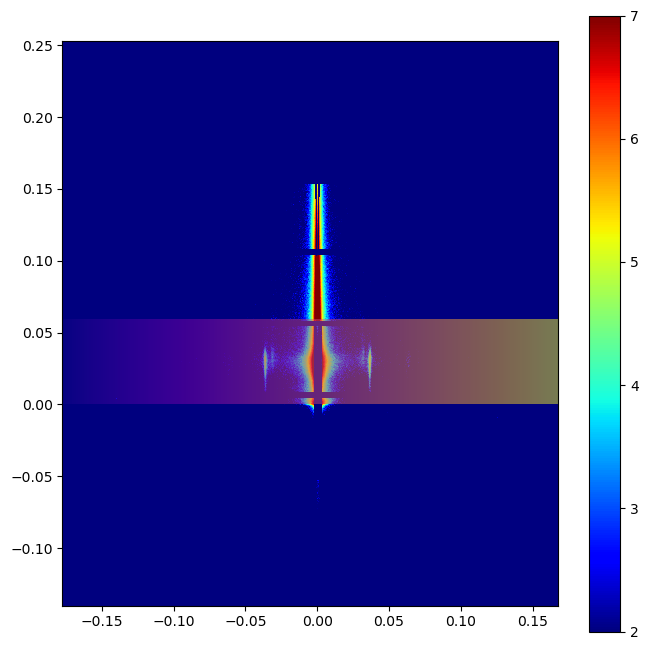

In [314]:
infile = infiles[0]
print(infile)

infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

## Plot scattering data
q_data = data.remesh_qr_bin(**run_args)
x_axis, y_axis = q_data.xy_axes()
extent = [x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]]


%matplotlib inline
plt.figure(1, figsize=(8,8)); plt.clf()
#plt.imshow(np.log(data.data+3), vmin=2, vmax=7); plt.colorbar() 
plt.imshow(np.log(q_data.data+3), vmin=2, vmax=7, cmap='jet', interpolation='nearest', extent=extent, origin='lower'); plt.colorbar()


### Linecut
if 1:
    qz = 0.03; dq = 0.03
    region = data.calibration.q_map()
    region = np.ma.masked_where(abs(data.calibration.qz_map()-qz)>dq, data.calibration.qr_map())
    plt.imshow(region, cmap='plasma', extent=extent, alpha=0.5)

if 0:
    qr = 0.03
    region = np.ma.masked_where(abs(data.calibration.qr_map()-qr)>dq, data.calibration.qz_map())
    plt.imshow(region, cmap='plasma', extent=extent)
    
### Angle
if 0:
    q0 = 0.05;
    dq = 0.001;
    region = np.ma.masked_where(abs(data.calibration.q_map()-q0)>dq, data.calibration.angle_map())
    plt.imshow(region, cmap='plasma', extent=extent)

### Sector
if 0:
    angle = 0
    dangle = 5
    region =  np.ma.masked_where(abs(data.calibration.angle_map()-angle)>dangle/2, data.calibration.q_map())
    plt.imshow(region, cmap='plasma', extent=extent)


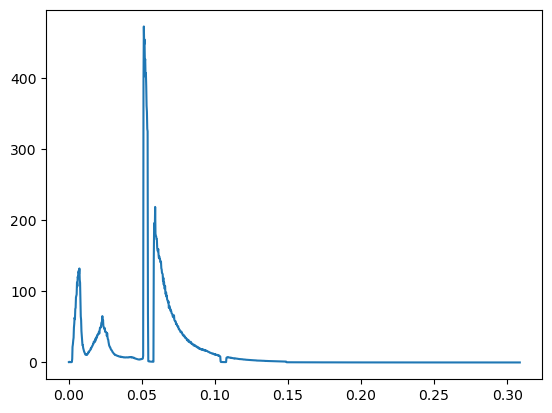

In [24]:
plt.plot(line_output.x, line_output.y)

In [25]:
exp.show()


=== Overview of experiment dictionary ===
exp.dict['expinfo']
  -  keys = ['expname', 'det', 'beamline', 'folder', 'ext', 'fn_patterns']
  -  key = expname, <class 'str'>, val = SC
  -  key = det, <class 'str'>, val = saxs
  -  key = beamline, <class 'str'>, val = cms
  -  key = folder, <class 'str'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk2/
  -  key = ext, <class 'str'>, val = tiff
  -  key = fn_patterns, <class 'list'>, val = ['SC*']
exp.dict['rawinfo']
  -  keys = ['filename', 'time', 'clock', 'scan_id', 'uid', 'filenumber', 'series_measure', 'num_frames']
  -  key = filename, <class 'list'>, len(shape) = 190
  -  key = time, <class 'list'>, len(shape) = 190
  -  key = clock, <class 'list'>, len(shape) = 190
  -  key = scan_id, <class 'list'>, len(shape) = 190
  -  key = uid, <class 'list'>, len(shape) = 190
  -  key = filenumber, <class 'int'>, val = 190
  -  key = series_measure, <class 'bool'>, val = False
  -  key = num_frames, <class 'list'>, val = []
exp.dict[

__Instead of doing analysis, can load previously analyzed data__

In [468]:
if 0:
    exp.loadSciAnalysisData(keys=['circular_average'], analysis_folder=str(exp.dict['folder'])+'waxs/analysis/PBG_run1/', verbose=1)
    exp.dict['analysis'].keys()

analysis_folder = /nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/waxs/analysis/PBG_run1/
[0%] 
[43%] 
[85%] 
loadSciAnalysisData time = 16.5s


dict_keys(['circular_average'])

## 4. Save 

Save experiment dictionary (exp.dict) to h5.

In [21]:
h5_path = EXPR_DIR+"/data/"
h5_file = str(exp.dict['expinfo']['expname']) + '_cms_exp.h5'
output_file = h5_path+h5_file


## Check if file exist, will not overwrite
if False:
    file_exist = os.path.isfile(output_file)
    count = 1
    while file_exist:
        print('{} exists, using a new filename'.format(output_file))
        h5_file = str(exp.dict['expname']) + '_exp_' + str(count) + '.h5'
        output_file = h5_path+h5_file
        file_exist = os.path.isfile(output_file)
        count = count + 1

        
## Save
dicttoh5(exp.dict, output_file)
print('Experiment saved as {}'.format(output_file))



Experiment saved as /nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl//data/MM389_KCl_cms_exp.h5


In [22]:
exp_dict_load['expinfo']

{'det': array('maxs', dtype='<U4'),
 'expname': array('MM389_KCl', dtype='<U9'),
 'fn_patterns': array(['*MM389*run4*'], dtype=object),
 'folder': array('/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl/',
       dtype='<U62'),
 'beamline': 'None'}

### __Load H5__

Load experiment dictionary and recover the object 'exp', allowing for subsequent data visualization/analysis.

In [2]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime, pprint
import sqlite3
import pandas as pd
from silx.io.dictdump import dicttoh5, h5todict
SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)
from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols
from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools


### Load experiment dict (previuosly analyzed data)
if True:
    
    #exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3//data/B6_N3_cms_exp.h5'
    #exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2//data/PBG_run1_cms_exp.h5'
    exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl//data/MM389_KCl_cms_exp.h5'
    exp_dict_load = h5todict(exp_dict_h5)
    #print(exp_dict_load.keys())
    
    exp = Experiment.experiment(exp_dict_load['expinfo']['expname'], folder=exp_dict_load['expinfo']['folder'], det=exp_dict_load['expinfo']['det'], beamline=exp_dict_load['expinfo']['beamline']) 
    exp.dict = exp_dict_load
    
    print(exp.dict.keys())
    print('\nExperiment loaded!')

dict_keys(['advanced', 'analysis', 'expinfo', 'metadata', 'rawinfo'])

Experiment loaded!


### __Overview of exp__

In [4]:
exp.show(verbose=1)


=== Overview of experiment dictionary ===
exp.dict['advanced']
  -  keys = []
exp.dict['analysis']
  -  keys = ['cali', 'circular_average']
  -  key = cali, <class 'numpy.ndarray'>, val = [9.184e-01 5.430e+02 6.060e+02 2.815e-01]
  -  key = circular_average
  -  -  keys = ['I_stack', 'q']
  -  -  key = I_stack, <class 'numpy.ndarray'>, val.shape = (3600, 748)
  -  -  key = q, <class 'numpy.ndarray'>, val.shape = (748,)
exp.dict['expinfo']
  -  keys = ['beamline', 'det', 'expname', 'fn_patterns', 'folder']
  -  key = beamline, <class 'numpy.ndarray'>, val = None
  -  key = det, <class 'numpy.ndarray'>, val = maxs
  -  key = expname, <class 'numpy.ndarray'>, val = MM389_KCl
  -  key = fn_patterns, <class 'numpy.ndarray'>, val = ['*MM389*run4*']
  -  key = folder, <class 'numpy.ndarray'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl/
exp.dict['metadata']
  -  keys = ['frames', 'sample_temperature_D']
  -  key = frames, <class 'numpy.ndarray'>, val.shape = (3600,)
 

## 5. Plot

### __(5.1) Data Trend__

#### &#9642; __Plot curves__

##### - __Load one curve & find peaks__

linecut_qr
SC_CS25_FP1_RPM3_T30_V18_pos1_x-0.000_th0.120_30.00s_1090675
fit_param = [height, width, prominence]
14 peaks found: [-0.0914 -0.0614 -0.0363 -0.0316 -0.0031 -0.0005  0.0005  0.0031  0.0312
  0.0359  0.0624  0.0757  0.0846  0.0914] for fit_prom 0.19708


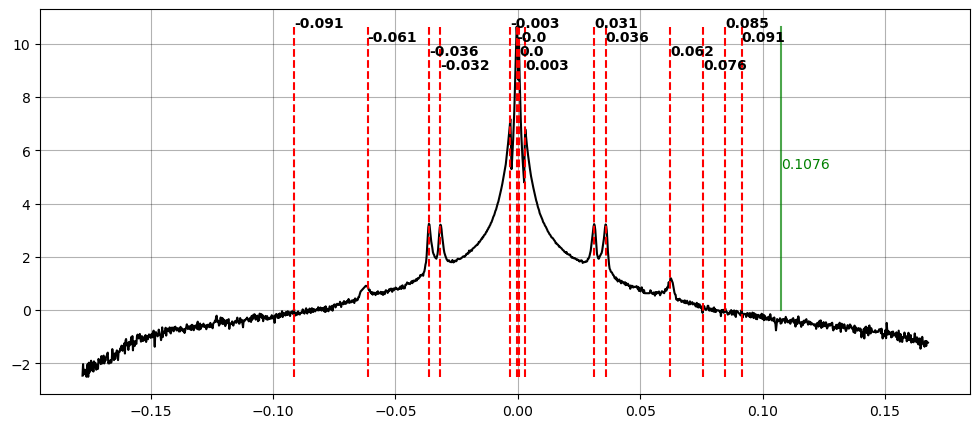

In [250]:
### Show one curve and find peaks
file_idx = 3
protocol = 'linecut_qr'
protocol = list(exp.dict['analysis'].keys())[-1]
print(protocol)
print(exp.dict['rawinfo']['filename'][file_idx])

## Pick a curve
line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  
flag_log = 1

%matplotlib inline
#%matplotlib ipympl
plt.figure(1, figsize=(12,5)); plt.clf()
q_peaks = Tools.plot_peaks(line_plot, N_peaks_find = 15, fit_param=[0, 1, 0.001], flag_log=flag_log, line_color='k', label_color='r', verbose=1)  #Tools.rand_color(0.5, 0.8)

q_label = [0.1076]
for q in q_label:
    if flag_log:
        y_range = [0, max(np.log(line_plot.y))]
    else:
        y_range = [min(line_plot.y), max(np.log(line_plot.y))]
    plt.plot([q, q], y_range, 'g',  alpha=0.7)
    plt.text(q, y_range[1]/2, str(q), color='g')


##### - __Plot all curves as 2D image__

In [221]:
I_stack.shape

(223, 1317)

/tmp/ipykernel_431938/2237306384.py:14: RuntimeWarning: divide by zero encountered in log
  I_stack = np.log(I_stack)


q_label = []


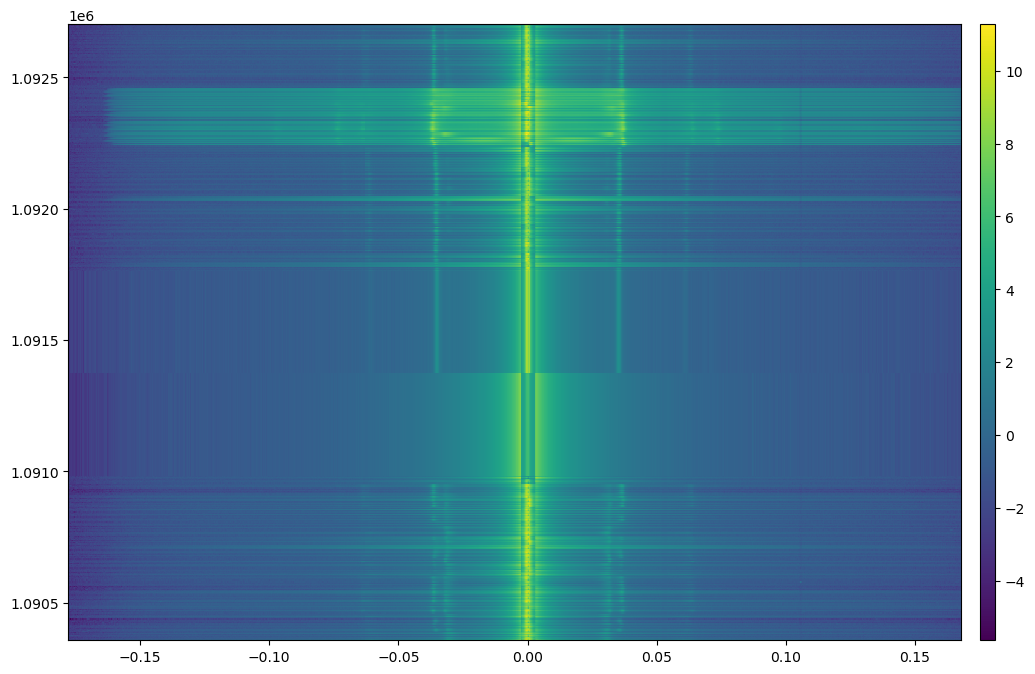

In [325]:
q_label = [] #q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines
flag_log = True

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[-1]


x_axis = exp.dict['analysis'][protocol]['q'] 
#y_axis = np.arange(0, I_stack.shape[0])
y_axis = exp.dict['rawinfo']['scan_id']
I_stack = exp.dict['analysis'][protocol]['I_stack']

if flag_log:
    I_stack = np.log(I_stack)
    
%matplotlib inline
plt.figure(2, figsize=(12,8)); plt.clf()
#plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), 0, I_stack.shape[0]],  aspect='auto') #aspect='auto' 0.005
plt.pcolormesh(x_axis, y_axis, I_stack)

cbar = plt.colorbar(fraction=0.02, pad=0.02, aspect=40) 
     
print('q_label = {}'.format(q_label))
for q in q_label:
    plt.plot([q, q], [0, I_stack.shape[0]], 'k',  alpha=0.2)
    

##### - __Plot curves__

/tmp/ipykernel_431938/1798417561.py:27: RuntimeWarning: divide by zero encountered in log
  I_stack = np.log(I_stack)


Text(0.5, 1.0, 'SC_CS1_NoFan_T30_V15_pos1_x-0.000_th0.050_30.00s_1090357, N=870')

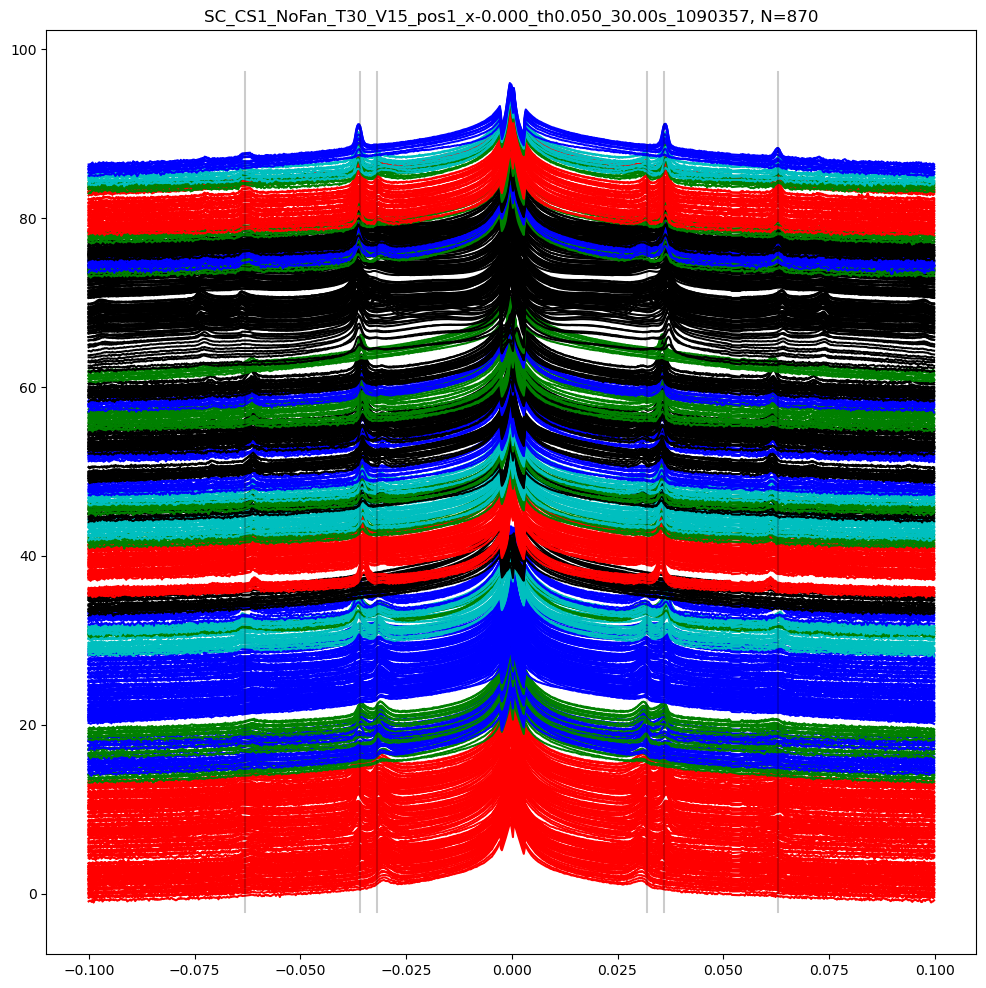

In [324]:
%matplotlib inline
plt.figure(1, figsize=(12,12)); plt.clf()
Nfiles = len(exp.dict['rawinfo']['filename'])
infile = exp.dict['rawinfo']['filename'][0]

qrange_plot = [-0.1, 0.1] ###
q_label = [-0.063, -0.036, -0.032, 0.032, 0.036, 0.063]; q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines

cmap = mpl.colormaps['jet'] #viridis, jet, hsv, brg
colors = cmap(np.linspace(0.0, 1.0, Nfiles))
flag_log = 1

#sample_temperature_D = exp.dict['metadata']['sample_temperature_D']
scan_ids = exp.dict['rawinfo']['scan_id']
filenames = exp.dict['rawinfo']['filename']

### Plot
protocol = 'linecut_qr'
x_axis = exp.dict['analysis'][protocol]['q'] 
idx_min = int(np.argmin(np.abs(x_axis-qrange_plot[0])))
idx_max = int(np.argmin(np.abs(x_axis-qrange_plot[1])))

I_stack = exp.dict['analysis'][protocol]['I_stack']
spacing_plot = 0.1 #arbitrary

if flag_log:
    I_stack = np.log(I_stack)
    
    
for ii, filename in zip(np.arange(Nfiles), filenames):
    #print('{}:, {}'.format(ii, filename))
    if 'NoFan' in filename: #sample_temperature_D[ii]>349.8:
        color = 'r'
        linestyle = None #'dashed' #dotted, dashed
    elif 'RPM1' in filename:
        color = 'g'
        linestyle = None
    elif 'RPM2' in filename:
        color = 'c'
        linestyle = None
    elif 'RPM3' in filename:
        color = 'b'
        linestyle = None
    else:
        color = 'k' #colors[ii]*0.8
        linestyle = None
        
    #if 'T50' in filename or 'T45' in filename or 'T40' in filename:
    #    linestyle = '-'
    #elif 'T35' in filename or 'T30' in filename:
    #    linestyle = '--'
    #elif 'T25' in filename:
    #    linestyle = ':'

    #if 'th0.0' in filename:
    #    color = 'k'
    #    linestyle = ':'
    #elif 'th0.1' in filename:
    #    color = [0.5, 0.5, 0.5]
    #    linestyle = '-'
        
    plt.plot(x_axis[idx_min:idx_max],I_stack[ii][idx_min:idx_max]+ii*spacing_plot, linestyle=linestyle, color=color, label=str(ii)+': '+filename[0:filename.find('pos1')]) #label=filename[0:filename.find('pos1')
    #if np.mod(ii,5)==0:
    #    plt.text(x_axis[idx_min], I_stack[ii][idx_min]+ii*spacing_plot, str(ii))
    #plt.grid('minor')

for q in q_label:
    plt.plot([q, q], [min(I_stack[0])*0.8, max(I_stack[0])*1.2+Nfiles*spacing_plot], 'k',  alpha=0.2)

    
#plt.legend(fontsize=7, ncols=2, bbox_to_anchor=(1.01, 1.01)) 
plt.title('{}, N={}'.format(infile.split('raw')[-1], Nfiles))



__Plot a 2D image__

/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk2//saxs/raw/SC_CS14_NoFan_T50_V21_pos1_x0.000_th0.150_30.00s_1090592_saxs.tiff


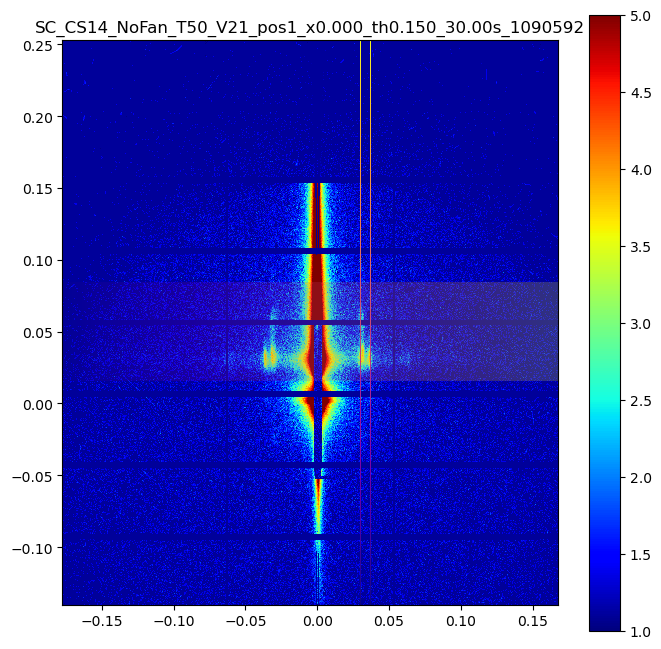

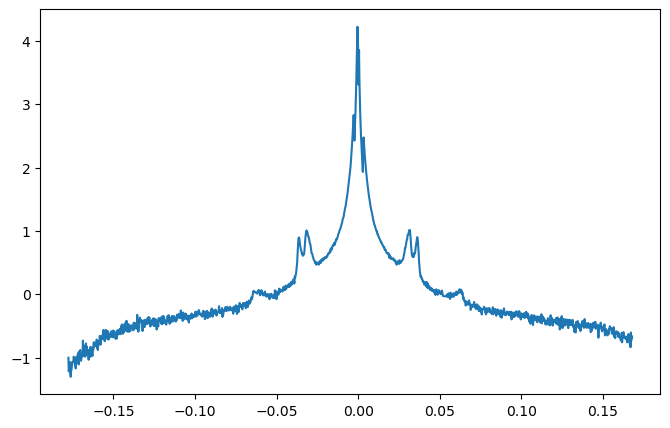

In [289]:
file_idx = 13;
infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][file_idx]+'_'+det+'.tiff'
print(infile_fullpath)
data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

## Plot scattering data
q_data = data.remesh_qr_bin(**run_args)
x_axis, y_axis = q_data.xy_axes()
extent = [x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]]

%matplotlib inline
plt.figure(1, figsize=(8,8)); plt.clf()
#plt.imshow(np.log(data.data+3), vmin=2, vmax=7); plt.colorbar() 
plt.imshow(np.log(q_data.data+3), vmin=1, vmax=5, cmap='jet', interpolation='nearest', extent=extent, origin='lower'); plt.colorbar()
plt.title(exp.dict['rawinfo']['filename'][file_idx])

### Linecut
if 1:
    qz = 0.05; dq = 0.035
    region = data.calibration.q_map()
    region = np.ma.masked_where(abs(data.calibration.qz_map()-qz)>dq, data.calibration.qr_map())
    plt.imshow(region, cmap='plasma', extent=extent, alpha=0.2)

    qr = 0.03; dq = 0.001
    region = np.ma.masked_where(abs(data.calibration.qr_map()-qr)>dq, data.calibration.qz_map())
    plt.imshow(region, cmap='plasma', extent=extent)

    qr = 0.037; dq = 0.001
    region = np.ma.masked_where(abs(data.calibration.qr_map()-qr)>dq, data.calibration.qz_map())
    plt.imshow(region, cmap='plasma', extent=extent)
    
## Plot reduced data
line_output = data.linecut_qr(qz = 0.05, dq = 0.035)
plt.figure(2, figsize=(8,5)); plt.clf()
plt.plot(line_output.x, np.log10(line_output.y))

#### &#9642; __Extract 0D feature & Plot 1D trend__

##### - __Load one curve for peak fitting__

{'fit_peaks_b': {'error': 0.03601067037866928, 'value': 2.417796980399773},
 'fit_peaks_chi_squared': 0.005683051891934417,
 'fit_peaks_d0': {'error': 0.021628569112629583, 'value': 20.390310642060168},
 'fit_peaks_d01': {'error': 0.021628569112629583, 'value': 20.390310642060168},
 'fit_peaks_d02': {'error': 0.014159127676188042, 'value': 17.37581214306398},
 'fit_peaks_grain_size': {'error': 3.8221203218423154,
                          'value': 164.6024196565317},
 'fit_peaks_grain_size1': {'error': 3.8221203218423154,
                           'value': 164.6024196565317},
 'fit_peaks_grain_size2': {'error': 12.685787274722424,
                           'value': 321.6150632140269},
 'fit_peaks_m': {'error': 1.067969441652097, 'value': -48.7020943130737},
 'fit_peaks_prefactor1': {'error': 0.028446874339259322,
                          'value': 1.4835838004150779},
 'fit_peaks_prefactor2': {'error': 0.038907828503888554,
                          'value': 1.1737272687859288},
 'fi

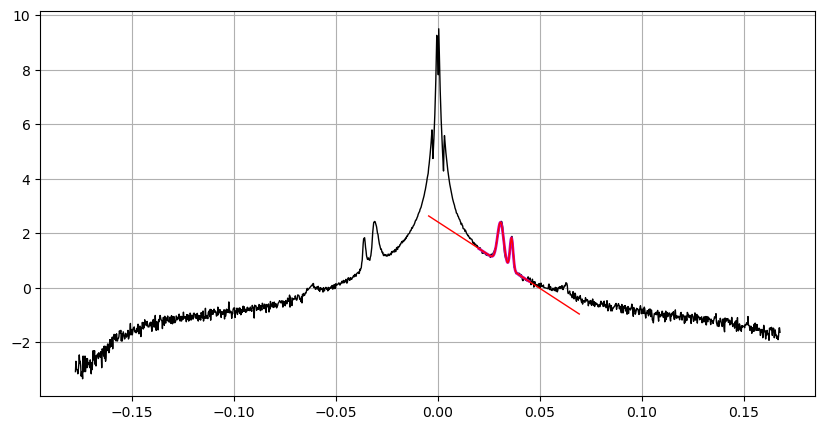

In [297]:
### Show one curve & do fitting
protocol = 'linecut_qr'

file_idx = 3
line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  

q0 = [0.03, 0.037] #[2.64964595, 3.07210364] #[1.82, 1.86]
fit_range = [0.02, 0.045] #[2.5, 3.2] #[1.7, 1.95]

flag_log = True
if flag_log == 1:
    line_plot.y = np.log(line_plot.y)

## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
results = {}
protocol = Protocols.fit_peaks()
lines = protocol._fit(line_plot, results, **run_args, q0=q0, num_curves=len(q0), fit_range=fit_range)

plt.figure(10, figsize=(10,5)); plt.clf()
for nn, line in enumerate(lines.lines):
        
    if nn==0: 
        plt.plot(line.x, line.y, 'k', linewidth=1, label=line.name)
        plt.title(line.name)
    elif nn==1:
        plt.plot(line.x, line.y, 'm', linewidth=2, label=line.name)
    else:
        plt.plot(line.x, line.y, 'r', linewidth=1, label=line.name)
        
    plt.grid()
    
pprint.pprint(lines.results)

##### - __Apply fitting for all__

In [308]:
protocol = 'linecut_qr'
q0 = [0.03, 0.037] #[2.64964595, 3.07210364] #[1.82, 1.86]
fit_range = [0.02, 0.045] #[2.5, 3.2] #[1.7, 1.95]


## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
p = Protocols.fit_peaks()
    

## Fitting all curves
peak_x1 = []
peak_x2 = []
peak_pre1 = []
peak_pre2 = []
t0 = time.time()
for ii in np.arange(Nfiles):
    line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][ii])  
    
    lines = p._fit(line_plot, results={}, **run_args, q0=q0, num_curves=len(q0), fit_range=fit_range)

    peak_x1.append(lines.results['fit_peaks_x_center1']['value'])
    peak_x2.append(lines.results['fit_peaks_x_center2']['value'])
    peak_pre1.append(lines.results['fit_peaks_prefactor1']['value'])
    peak_pre2.append(lines.results['fit_peaks_prefactor2']['value'])

print('Fitting {} files took {:.0f}s\n'.format(Nfiles, time.time()-t0))

#Ts = exp.dict['metadata']['sample_temperature_D']
#scan_ids = exp.dict['rawinfo']['scan_id']


Fitting 34 files took 0s



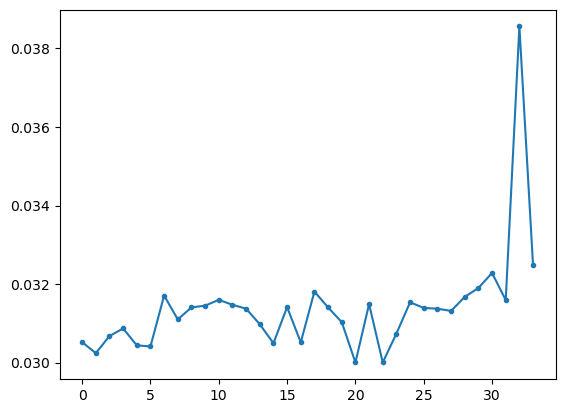

In [309]:
plt.plot(peak_x1, '.-')

In [136]:
exp.dict['analysis']['circular_average']['fit_peaks_x_center1'] = peak_x1
#exp.dict['analysis']['circular_average']['fit_peaks_x_center2'] = peak_x2
exp.show()


=== Overview of experiment dictionary ===
exp.dict['expinfo']
  -  keys = ['expname', 'det', 'beamline', 'folder', 'fn_patterns']
  -  key = expname, <class 'str'>, val = PBG_run1
  -  key = det, <class 'str'>, val = waxs
  -  key = beamline, <class 'str'>, val = cms
  -  key = folder, <class 'str'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/
  -  key = fn_patterns, <class 'list'>
exp.dict['rawinfo']
  -  keys = ['filename', 'time', 'clock', 'scan_id', 'uid', 'filenumber', 'series_measure', 'num_frames']
  -  key = filename, <class 'list'>, len(shape) = 29
  -  key = time, <class 'list'>, len(shape) = 29
  -  key = clock, <class 'list'>, len(shape) = 29
  -  key = scan_id, <class 'list'>, len(shape) = 29
  -  key = uid, <class 'list'>, len(shape) = 29
  -  key = filenumber, <class 'int'>, val = 29
  -  key = series_measure, <class 'bool'>, val = False
  -  key = num_frames, <class 'list'>, val = []
exp.dict['analysis']
  -  keys = ['cali', 'circular_average']
  -

In [30]:
#Convert list or dict to dataframe:
df_list = pd.DataFrame(peak_x1, columns=['peak_x1'])


__(Alternatively, other feature extration, e.g. q with max intensity)__

In [ ]:
### Get the q with max intensity within this range

protocol = 'circular_average'
y = []
for ii in np.arange(Nfiles):
    line_plot = DataLine(x = exp.dict['data'][protocol][str(ii)]['q'], y = exp.dict['data'][protocol][str(ii)]['I(q)'])  
    line_x = line_plot.x
    line_y = line_plot.y
    y.append(line_y[idx_min:idx_max])
    
qrange_plot = [1, 1.5] 


Ts = exp.dict['metadata']['sample_temperature_D']
scan_ids = exp.dict['expinfo']['scan_id']

idx_min = int(np.argmin(np.abs(x_axis-qrange_plot[0])))
idx_max = int(np.argmin(np.abs(x_axis-qrange_plot[1])))

x_axis = line_x
q_peakmax_list = []
data_show = []
for ii in np.arange(len(y)):
    line_y = y[ii]
    line_y_crop = line_y[idx_min:idx_max]
    line_x_crop = x_axis[idx_min:idx_max]
    q_peakmax = line_x_crop[np.argmax(line_y_crop)]
    q_peakmax_list.append(q_peakmax)
    data_show.append([Ts[ii], scan_ids[ii], q_peakmax])

df_line_s = pd.DataFrame(q_peakmax_list, columns=['I'])
df_show = pd.DataFrame(data_show, columns = ['RH', 'scan_id', 'q_peakmax'])

print(q_peakmax_list[0:5])

##### - __Compare three 1D curves__

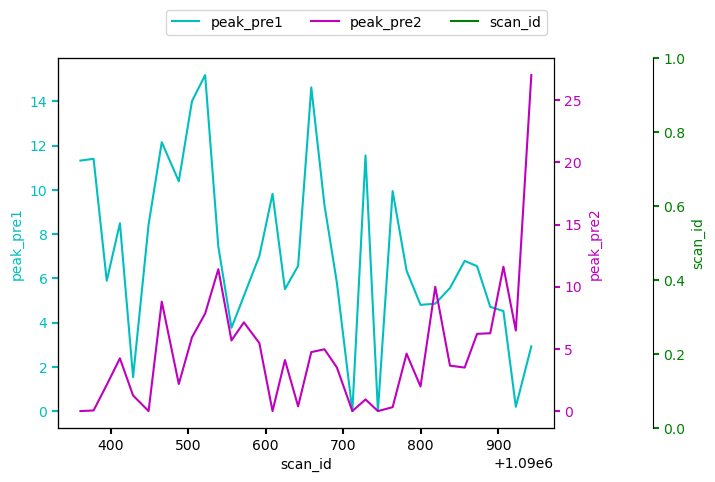

In [313]:
#Ts = exp.dict['metadata']['sample_temperature_D']
scan_ids = exp.dict['rawinfo']['scan_id']


fig, ax = plt.subplots()
#fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.2))


if 0:
    labels = ["peak_pe1", "peak_pre2", "scan_id"]
    p1, = ax.plot(scan_ids, peak_x1, "b-", label=labels[0])
    p2, = twin1.plot(scan_ids, peak_x2, "r-", label=labels[1])
    p3, = twin2.plot(scan_ids, scan_ids, "g-", label=labels[2])
else:
    p1, = ax.plot(scan_ids, peak_pre1, "c-", label="peak_pre1")
    p2, = twin1.plot(scan_ids, peak_pre2, "m-", label="peak_pre2")
    #p3, = twin2.plot([0, 1, 2], [50, 30, 15], "g-", label="Humidity")
    

#ax.set_xlim(0, 2)
#ax.set_ylim(0, 2)
#twin1.set_ylim(0, 4)
#twin2.set_ylim(1, 65)

ax.set_xlabel("scan_id")
ax.set_ylabel(labels[0])
twin1.set_ylabel(labels[1])
twin2.set_ylabel(labels[2])

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3], ncols=3, bbox_to_anchor=(1, 1.15))
plt.show()

#### &#9642; __Extract 0d feature & Plot 2D map__

In [ ]:
### ROI
if 0:
    reduced_data = exp.dict['data']['roi']
    print('Len(reduced_data) = {}'.format(len(reduced_data)))
    print(reduced_data.keys())

    feature_list = []
    for ii in np.arange(0,len(reduced_data)):
        feature_list.append(reduced_data['stats_average'][ii])

In [481]:
### Angle

reduced_data = exp.dict['data']['linecut_angle']
print('Len(reduced_data) = {}'.format(len(reduced_data)))

x_pos = exp.dict['metadata']['sample_x']
y_pos = exp.dict['metadata']['sample_y']


feature_list = []
for ii in np.arange(0,len(reduced_data)):
    angle = reduced_data[str(ii)]['q']
    I = reduced_data[str(ii)]['I(q)']
    chi = angle[np.argmax(I)]
    feature_list.append(chi)


Len(reduced_data) = 3450


##### - __Plot scalar 2D mage__

(-2.5, 2.4000500000000002, -1.8000500000000001, 1.6000500000000002)

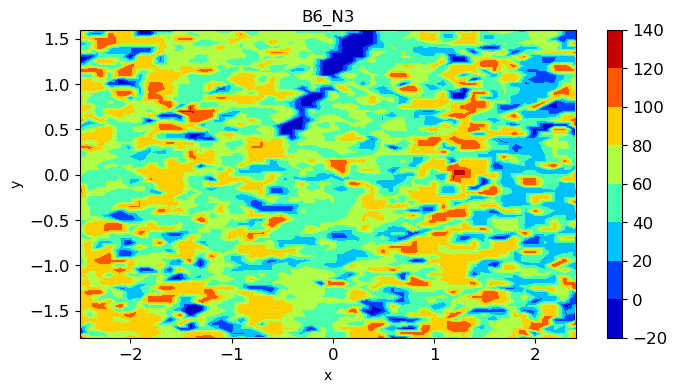

In [482]:
plt.figure(); plt.clf()

#plt.tripcolor(x_pos, y_pos, feature_list)  
plt.tricontourf(x_pos, y_pos, feature_list, cmap = 'jet') 

plt.colorbar()
plt.xlabel('x'); plt.ylabel('y')
plt.title(exp.dict['expname'])
plt.axis('equal')
plt.axis('tight')

#plt.plot(x_pos, y_pos, 'k.')

__Plot scalar image with interpolation__

(-2.5, 2.3999999999998956, -1.8000500000000001, 1.5999499999999274)

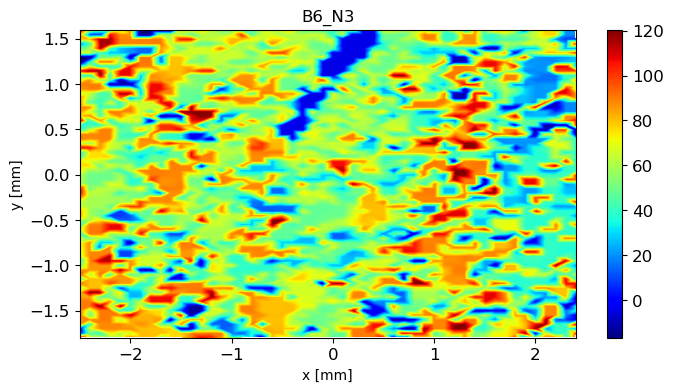

In [437]:
plot_interp = ['linear', 0.005] 
x_pos_fine, y_pos_fine, feature = Tools.interp_map(x_pos, y_pos, feature_list, plot_interp) 

plt.figure(); 
extent = (np.nanmin(x_pos_fine), np.nanmax(x_pos_fine), np.nanmin(y_pos_fine), np.nanmax(y_pos_fine))

plt.imshow(feature, extent=extent, origin='lower', cmap='jet') #, clim=[-180, 180])  
plt.colorbar()
plt.xlabel('x [mm]'); plt.ylabel('y [mm]')
plt.title(exp.dict['expname'])
plt.axis('equal')
plt.axis('tight')

##### - __Plot quiver__

In [438]:
u_list = []
v_list = []
chi_list = []
for chi in feature_list:
    u = np.cos(np.deg2rad(chi)) 
    v = np.sin(np.deg2rad(chi)) 
    u_list.append(u)
    v_list.append(v)
    chi_list.append(chi)

Text(0.5, 1.0, 'PBG_run1')

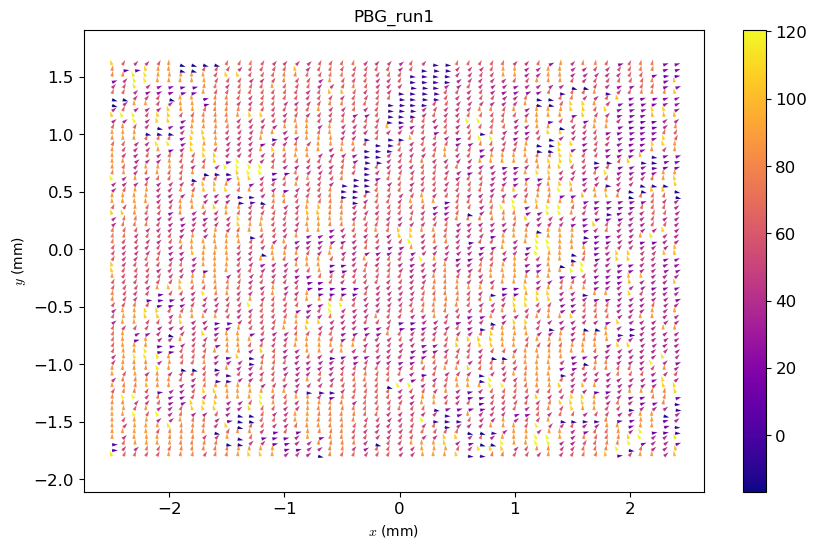

In [459]:
fig, ax = plt.subplots(figsize=[10, 6])

q = ax.quiver(x_pos, y_pos, u_list, v_list, chi_list, cmap = 'plasma') #,clim=[0,0.3])

#ax.set_xlim([-0.2,5])
#ax.set_ylim([-0.2,5])
ax.axis('equal')
ax.set_xlabel('$x$ (mm)'); ax.set_ylabel('$y$ (mm)')

cb = plt.colorbar(q)
plt.title(exp.dict['expname'])
# plt.savefig('SAXS mapping_quiver polt_colorbar.png', dpi = 600)


### __(5.2) Experiment__

#### &#9642; __Fitting for experiment__

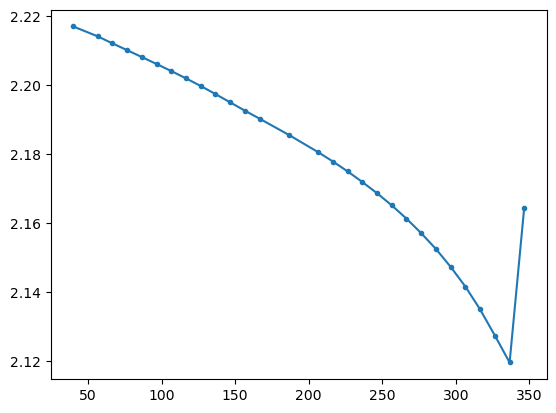

In [137]:
curve_1 = exp.dict['metadata']['sample_temperature_D']
curve_2 = exp.dict['analysis']['circular_average']['fit_peaks_x_center1']


plt.plot(curve_1, curve_2, '.-')
#plt.plot(curve_2)

In [165]:
from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
#from SciAnalysis.XSAnalysis import Protocols
from SciAnalysis.CurveAnalysis.Data import *

#line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  
line_plot = DataLineStructuredSort(x = np.asarray(curve_1)*0.1, y = curve_2)


In [168]:
lm_result, fit_line, fit_line_extended = line_plot.fit_linear(line_plot, **run_args)


In [2]:
#lm_result

[2.22268847 2.21802335 2.21521305 2.21240274 2.20959243 2.20678212
 2.20394371 2.2011615  2.19835119 2.19554089 2.19273058 2.18989217
 2.18710996 2.18148934 2.17586873 2.17303031 2.17024811 2.1674378
 2.16462749 2.16181718 2.15903498 2.15622467 2.15338626 2.15057595
 2.14776564 2.14498343 2.14214502 2.13933471 2.13655251]


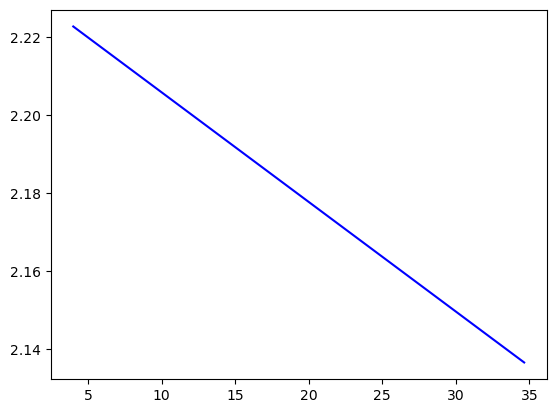

In [178]:
plt.plot(fit_line.x, fit_line.y, 'b')
#plt.plot(fit_line_extended.x, fit_line_extended.y, 'r:')
print(fit_line.y)

### (5.3) Bad ideas

#### &#9642; Perform correlation 

In [461]:
print('Analysis data: {}\n'.format(exp.dict['data'].keys()))
exp.doCorr(corrs = [['2Darray']])

print(exp.dict['corrdata']['2Darray']['circular_average'].keys())
print(exp.dict['data']['circular_average'][str(0)].keys())

Analysis data: dict_keys(['circular_average'])

doCorr circular_average
dict_keys(['I(q)', 'I_array', 'file_index', 'scan_id', 'time', 'sample_clock', 'sample_temperature_D'])
dict_keys(['I(q)', 'q'])


#### &#9642; Plot data

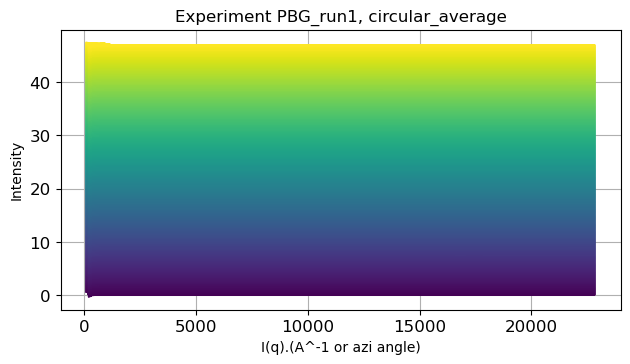

In [462]:
%matplotlib inline

exp.plotWaterfall(key = 'circular_average', y_spacing=0.1, flag_log=[0, 1])
#exp.plotWaterfall(key = 'sector_average', y_spacing=1)
#exp.plotWaterfall(key = 'linecut_qz', y_spacing=100)

/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/SciAnalysis/ExpAnalysis/Experiment.py:518: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_axis[plot_xrange], y_idx, I_array[:,plot_xrange])


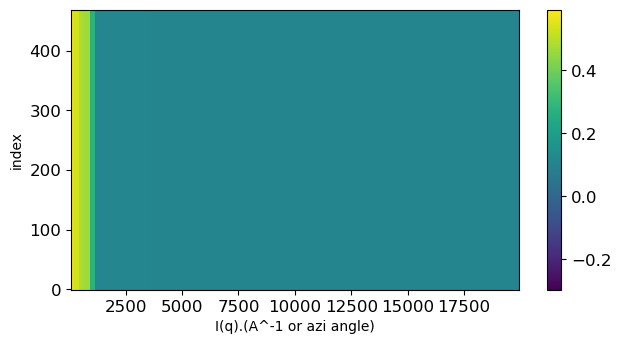

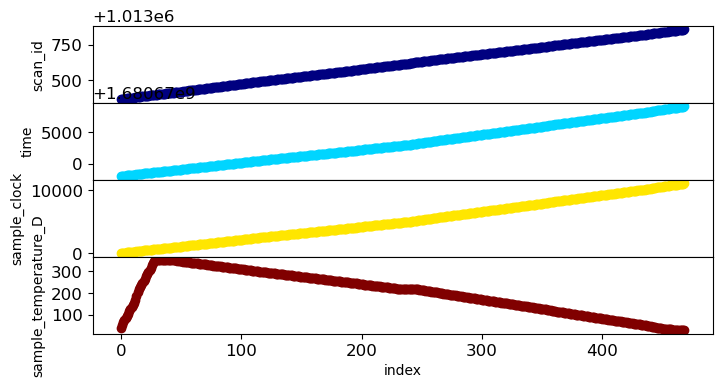

In [463]:
exp.plotHeatmap(key = protocol)

## 6. &#9733; Batch Processing 

Can be done in background with 'python runXS.py'

(If this section gets stuck for whatever reason, restart the kernal.)

In [ ]:
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3/'  ###CHANGE THIS

stitched = 1
pattern = '*'


if stitched==0:
    source_dir = EXPR_DIR+'/'+det+'/raw/' 
    output_dir = EXPR_DIR+'/'+det+'/analysis/'
else:
    source_dir = EXPR_DIR+'/'+det+'/stitched/'
    output_dir = EXPR_DIR+'/'+det+'/stitched_analysis/'


infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff'))
infiles.sort()

mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
if stitched:
    mask = Mask(mask_dir+'Dectris/Pilatus2M_vertical_gaps-mask.png')
else:
    mask = Mask(mask_dir+'Dectris/Pilatus2M_gaps-mask.png')

if load_custom_mask:
    mask.load(custom_mask)       

load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            'rcParams': {'axes.labelsize': 25,
                            'xtick.labelsize': 18,
                            'ytick.labelsize': 18,
                            'xtick.major.pad': 5,
                            'ytick.major.pad': 5,
                            },
            }

process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

# Examples:
#protocols = [ Protocols.circular_average_q2I(plot_range=[0, 0.2, 0, None]) ]
#protocols = [ Protocols.linecut_angle(q0=0.01687, dq=0.00455*1.5, show_region=False) ]
#protocols = [ Protocols.q_image(blur=1.0, bins_relative=0.5, plot_range=[-0.1, 3.0, 0, 3.0], _xticks=[0, 1.0, 2.0, 3.0], ztrim=[0.2, 0.01]) ]
#protocols = [ Protocols.qr_image(blur=1.0, bins_relative=0.5, plot_range=[-0.1, 3.0, 0, 3.0], _xticks=[0, 1.0, 2.0, 3.0], zmin=1010., ztrim=[None, 0.01]) ]
#protocols = [ Protocols.qr_image(blur=None, bins_relative=0.8, plot_range=[-0.1, 3.0, 0, 3.0], _xticks=[0, 1.0, 2.0, 3.0], ztrim=[0.38, 0.002], dezing_fill=True) ]
#protocols = [ Protocols.q_phi_image(bins_relative=0.25, plot_range=[0, 3.0, 0, +90]) ]
# Protocols.sector_average(angle=-70, dangle=25, show_region=False) 
# Protocols.qr_image(blur=None, colorbar=True, save_data=False, transparent=False, label_filename=True) 
# Protocols.linecut_q(chi0= 90+70, dq= .5, gridlines=True, label_filename=True, save_results = [ 'hdf5' ] )
# Protocols.HDF5(  save_results = [ 'hdf5' ] )
# Protocols.metadata_extract()

protocols = [
    #Protocols.HDF5(save_results=['hdf5'])
    #Protocols.calibration_check(show=False, AgBH=True, q0=1.076, dq=0.005, num_rings=10, ztrim=[0.2, 0.01], dpi=300) ,
    
    #Protocols.circular_average(ylog=True, plot_range=[0, 0.18, None, None], dezing=True, gridlines=True, transparent=False, label_filename=True) ,
    #Protocols.linecut_qr(name='linecut_qr0.025', qz=0.025, dq=0.02, ylog=True, show_region=True, gridlines=True); #dq is half-width
    #Protocols.thumbnails(crop=None, resize=0.5, cmap=cmap_vge, ztrim=[0.06, 0.001], zmin=1000.0) , # PSCCD
    
    #Protocols.thumbnails(crop=None, resize=0.5, cmap=cmap_vge, ztrim=[0.02, 0.001]) , # Pilatus800k
    #Protocols.thumbnails(name='thumbnails_jet', crop=None, ztrim=[0.06, 0.001]) , # Pilatus800k

    Protocols.qr_image(blur=None, colorbar=True, save_data=False, transparent=False, label_filename=True, plot_buffers = [0.1, 0.1, 0.1, 0.1]),    
    #Protocols.q_image(blur=None, colorbar=True, save_data=False, transparent=False, label_filename=True, plot_buffers = [0.1, 0.1, 0.1, 0.1], dpi=200) 
    Protocols.linecut_qr(ylog=True, name='linecut_qr_qz0.03', qz=0.03, dq=0.02, show_region='save', label_filename=True, gridlines=True),
    ]
    
# To stitch files: 
# 1) run stitch.py to stitch into .TIFF 
# 2) run runStitched.py to generate thumbnails etc

# Run
########################################
print('Processing {} infiles...'.format(len(infiles)))
process.run(infiles, protocols, output_dir=output_dir, force= 0)

print('Done!')

# Loop
########################################
# This is typically only used at the beamline (it loops forever, watching for new files).
#process.monitor_loop(source_dir=source_dir, pattern=pattern+'*.tiff', protocols=protocols, output_dir=output_dir, force=False)



Processing 230 infiles...
 Skipping qr_image for BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.050_30.00s_1136063_saxs_stitched
 Skipping linecut_qr_qz0.03 for BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.050_30.00s_1136063_saxs_stitched
 Skipping qr_image for BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.080_30.00s_1136064_saxs_stitched
Running linecut_qr_qz0.03 for BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.080_30.00s_1136064_saxs_stitched


/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/SciAnalysis/Data.py:452: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  self.ax.axis( [xi, xf, yi, yf] )


  DB locked (attempt 1); retrying...
 Skipping qr_image for BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.100_30.00s_1136065_saxs_stitched
Running linecut_qr_qz0.03 for BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.100_30.00s_1136065_saxs_stitched
  DB locked (attempt 1); retrying...
 Skipping qr_image for BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.120_30.00s_1136066_saxs_stitched
Running linecut_qr_qz0.03 for BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.120_30.00s_1136066_saxs_stitched
 Skipping qr_image for BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.150_30.00s_1136067_saxs_stitched
Running linecut_qr_qz0.03 for BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.150_30.00s_1136067_saxs_stitched
  DB locked (attempt 1); retrying...
 Skipping qr_image for BB_BB_S3_P4VP-OH_BefSVA_pos1_x-0.000_th0.050_30.00s_1136043_saxs_stitched
Running linecut_qr_qz0.03 for BB_BB_S3_P4VP-OH_BefSVA_pos1_x-0.000_th0.050_30.00s_1136043_saxs_stitched


## 7. Stitching

Take multiple data at different detector positions to fill in the detector module gaps.

(Originally in /nsls2/data/cms/legacy/xf11bm/software/StitchPilatus/)

In [5]:
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from PIL import Image 

import sys, os
import glob

#### &#9642; __Pilatus2M__

In [13]:
#mask session
mask_folder = '/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/SciAnalysis/XSAnalysis/masks/'
mask = mask_folder + 'Dectris/Pilatus2M_gaps-mask.png'

mask1 = Image.open(mask).convert('I') # 'I' : 32-bit integer pixels
mask1_data = np.copy( np.asarray(mask1))
mask1_data = mask1_data/np.max(mask1_data)

mask_black = Image.new('L', (1475,1679), 'black')

#mask2
mask2_new = Image.new('I', (1475,1679), 'white')

#mask2 = mask1
mask2_cut = mask1.crop((0, 30 ,1475, 1679 ))
mask2_new.paste(mask2_cut)
mask2_black = mask_black.crop((0,  1679 -30 ,1475,1679 ))
mask2_new.paste(mask2_black, [0,  1679 -30])
mask2_new = mask2_new/np.max(mask2_new)

#mask3
mask3_new = Image.new('I', (1475,1679), 'white')

#mask3 = mask1
mask3_cut = mask1.crop((30 , 0, 1475, 1679))
mask3_new.paste(mask3_cut)
mask3_black = mask_black.crop((1475 -30 , 0, 1475, 1679 ))
mask3_new.paste(mask3_black, [1475 -30, 0])
mask3_new = mask3_new/np.max(mask3_new)


#mask4
mask4_new = Image.new('I', (1475,1679), 'white')

#mask3 = mask1
mask4_cut = mask1.crop((30 , 30, 1475, 1679))
mask4_new.paste(mask4_cut)
mask4_black1 = mask_black.crop((0,  1679 -30 ,1475,1679 ))
mask4_black2 = mask_black.crop((1475 -30 , 0, 1475, 1679 ))

mask4_new.paste(mask4_black1, [0,  1679 -30])
mask4_new.paste(mask4_black2, [1475 -30, 0])
mask4_new = mask4_new/np.max(mask4_new)

img2_new = Image.new('I', (1475, 1679), 'white')
img3_new = Image.new('I', (1475, 1679), 'white')
img4_new = Image.new('I', (1475, 1679), 'white')
    
#Stitch functions
def stitch_4images(infile, infile2, infile3, infile4):

    #load images to data array
    img = Image.open(infile).convert('I') # 'I' : 32-bit integer pixels
    data = np.copy( np.asarray(img) )
    img2 = Image.open(infile2[0]).convert('I') # 'I' : 32-bit integer pixels
    data2 = np.copy( np.asarray(img2) )    
    img3 = Image.open(infile3[0]).convert('I') # 'I' : 32-bit integer pixels
    data3 = np.copy( np.asarray(img3) )    
    img4 = Image.open(infile4[0]).convert('I') # 'I' : 32-bit integer pixels
    data4 = np.copy( np.asarray(img4) )    

    
    #move the data to the original position
    
    img2_cut = img2.crop((0, 30 ,1475, 1679))
    img2_new.paste(img2_cut)
    data2_data = np.copy( np.asarray(img2_new) )
    img3_cut = img3.crop((30, 0 ,1475, 1679))
    img3_new.paste(img3_cut)
    data3_data = np.copy( np.asarray(img3_new) )
    img4_cut = img4.crop((30, 30 ,1475, 1679))
    img4_new.paste(img4_cut)
    data4_data = np.copy( np.asarray(img4_new) )

    #merge masks
    data1_new= data*mask1_data
    data2_new = data2_data*mask2_new
    data3_new= data3_data*mask3_new
    data4_new = data4_data*mask4_new

    
    #data output
    final_data = (data1_new+data2_new+data3_new+data4_new)/(mask1_data+mask2_new+mask3_new+mask4_new)
#    final_data = (data1_new+data2_new+data3_new)/(mask1_data+mask2_new+mask3_new)
#    final_data = (data1_new+data4_new)/(mask1_data+mask4_new)
    
    final_img = Image.fromarray((final_data).astype(np.uint32))

    return final_img    
    
#only two positions for ygaps
def stitch_2images(infile, infile2):

    #load images to data array
    img = Image.open(infile).convert('I') # 'I' : 32-bit integer pixels
    data = np.copy( np.asarray(img) )
    
    if infile2 != []:
        img2 = Image.open(infile2[0]).convert('I') # 'I' : 32-bit integer pixels
#         img2 = Image.open(infile2).convert('I'|) # 'I' : 32-bit integer pixels
        data2 = np.copy( np.asarray(img2) )    

        #move the data to the original position    
        img2_cut = img2.crop((0, 30 ,1475, 1679))
        img2_new.paste(img2_cut)
        data2_data = np.copy( np.asarray(img2_new) )

        #merge masks
        data1_new= data*mask1_data
        data2_new = data2_data*mask2_new

        #data output
        final_data = (data1_new+data2_new)/(mask1_data+mask2_new)
    #    plt.imshow(np.log(final_data), cmap="hot");plt.colorbar();plt.clim(-1, 3)
    else:
        final_data = data*mask1_data

    final_data[np.isnan(final_data)]=-2
    final_img = Image.fromarray((final_data).astype(np.uint32))
#     infile_done = 'stitched/{}_{}.tiff'.format(infile[2:-5],'stitched')
    
#     final_img.save(infile_done)  
    return final_img

def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 

def stitch_2images_folder(folder, infiles=None, interval=1, force=False):
    source_dir = folder + '/saxs/raw/'#'/maxs/raw/'   
    output_dir = folder + '/saxs/stitched/'#'/maxs/stitched/'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos1*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infiles)))
    
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        infile_name_full = infile_filename.split('_pos1_')
        print(infile_name[-2])
       # print(infile_name)
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos1':
                number = int(infile_name[-2])
                infile2 = glob.glob(os.path.join(source_dir, '{}*pos2*{}*.tiff'.format(infile_name_full[0],str(number+interval) )))
                print("Matched to       :  {}".format(infile2))   
#                 print('TEST: filename = {}'.format(infile_name_full[0]))
                

        if infile2 != []:
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            if os.path.isfile(infile_done)==False or force==True:
                final_data = stitch_2images(infile, infile2)
                processed_count += 1
                final_data.save(infile_done)
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
        
         
        
    print("Processed {} files".format(processed_count))
    print("Errors on  {} files".format(error_count))
    print("    Those errors were on:")
    print(files_with_errors)            

def stitch_2images_folderlist(folder, infiles=None, interval=1, force=False):
    #doesnot care the infile name in pos2 images
    
    source_dir = folder + '/saxs/raw/'#'/maxs/raw/'   
    output_dir = folder + '/saxs/stitched/'#'/maxs/stitched/'

    
    source_dir = folder + '/saxs/raw/'
    output_dir = folder + '/saxs/stitched/'#'/maxs/stitched/'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos1*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infiles)))
    
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        infile_name_full = infile_filename.split('_pos1_')
        print(infile_name[-2])
       # print(infile_name)
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos1':
                number = int(infile_name[-2])
                infile2 = glob.glob(os.path.join(source_dir, '*pos2*{}*.tiff'.format(str(number+interval) )))
                print("Matched to       :  {}".format(infile2))   
#                 print('TEST: filename = {}'.format(infile_name_full[0]))
                

        if infile2 != []:
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            if os.path.isfile(infile_done)==False or force==True:
                final_data = stitch_2images(infile, infile2)
                processed_count += 1
                final_data.save(infile_done)
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
        
         
        
    print("Processed {} files".format(processed_count))
    print("Errors on  {} files".format(error_count))
    print("    Those errors were on:")
    print(files_with_errors)            
def stitch_4images_folder(folder, infiles=None, interval=1, force=False):
    source_dir = folder + '/saxs/raw/'   
    output_dir = folder + '/saxs/stitched/'
    if os.path.isdir(source_dir)==False:
        return
    
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)

    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos1*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infiles)))

    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        infile_name_full = infile_filename.split('_pos1_')
        print(infile_name[-2])
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos1':
                number = int(infile_name[-2])
                infile2 = glob.glob(os.path.join(source_dir, '{}*pos2*{}*.tiff'.format(infile_name_full[0],str(number+interval*1) )))
                infile3 = glob.glob(os.path.join(source_dir, '{}*pos3*{}*.tiff'.format(infile_name_full[0],str(number+interval*3) )))
                infile4 = glob.glob(os.path.join(source_dir, '{}*pos4*{}*.tiff'.format(infile_name_full[0],str(number+interval*2) )))
                print(infile2)   

        if infile2 != [] and  infile3 != [] and  infile4 != []:
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            if os.path.isfile(infile_done)==False or force==True:
                final_data = stitch_4images(infile, infile2, infile3, infile4)
                processed_count += 1
                final_data.save(infile_done)
      

        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
            
def stitch_2images_filelist(folder, infiles=None, interval=1, force=False):
    source_dir = folder + '/saxs/raw/'   
    output_dir = folder + '/saxs/stitched/'
#     output_dir = folder + '/waxs/stitched/2images'

    pos1_filelist = folder + 'SAXS_pos1_list.csv'
    pos2_filelist = folder + 'SAXS_pos2_list.csv'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
        
    with open(pos1_filelist) as file:
        pos1_lines = file.readlines()    
    with open(pos2_filelist) as file:
        pos2_lines = file.readlines()    
    
    for ii in range(len(pos2_lines)):
        
        infile = folder+pos1_lines[ii].rstrip()
        infile2 = folder+pos2_lines[ii].rstrip()

        print(infile)
        
        infile_done = output_dir +'{}_{}.tiff'.format(pos1_lines[ii].split('/')[-1].rstrip()[:-5],'stitched')
        if os.path.isfile(infile_done)==False or force==True:
            final_data = stitch_2images(infile, infile2)
#             processed_count += 1
            final_data.save(infile_done) 

            print("Fist data at pos1:  {}".format(infile))   
            print("Matched to       :  {}".format(infile2))   
        else:
            
            print('the file has been generated')

##### __Stitch ygap__

In [14]:
source_dir = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3/'
stitch_2images_folder(folder=source_dir, interval=5)


/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//saxs/raw/BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.050_30.00s_1136063_saxs.tiff
1136063
Matched to       :  ['/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//saxs/raw/BB_BB_S3_P4VP-OH_AftSVA_pos2_x-0.000_th0.050_30.00s_1136068_saxs.tiff']


/tmp/ipykernel_56090/3622293862.py:113: RuntimeWarning: invalid value encountered in divide
  final_data = (data1_new+data2_new)/(mask1_data+mask2_new)


/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//saxs/raw/BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.080_30.00s_1136064_saxs.tiff
1136064
Matched to       :  ['/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//saxs/raw/BB_BB_S3_P4VP-OH_AftSVA_pos2_x-0.000_th0.080_30.00s_1136069_saxs.tiff']
/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//saxs/raw/BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.100_30.00s_1136065_saxs.tiff
1136065
Matched to       :  ['/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//saxs/raw/BB_BB_S3_P4VP-OH_AftSVA_pos2_x-0.000_th0.100_30.00s_1136070_saxs.tiff']
/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//saxs/raw/BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.120_30.00s_1136066_saxs.tiff
1136066
Matched to       :  ['/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//saxs/raw/BB_BB_S3_P4VP-OH_AftSVA_pos2_x-0.000_th0.120_30.00s_1136071_saxs.tiff']
/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//saxs/raw/BB_BB_S3_P4VP-OH_AftSVA_pos1_x-0.000_th0.150_30.00s_1136067_saxs

#### &#9642; __Pilatus800k__

In [ ]:
mask_folder = '/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/SciAnalysis/XSAnalysis/masks/'
mask = mask_folder + 'Dectris/Pilatus800k_gaps-mask.png'
# mask = mask_folder + 'Dectris/Pilatus800_current-mask_extrawideblock.png'

mask1 = Image.open(mask).convert('I') # 'I' : 32-bit integer pixels
mask1_data = np.copy( np.asarray(mask1))
mask1_data = mask1_data/np.max(mask1_data)

mask_black = Image.new('L', (981,1043), 'black')

#mask2
mask2_new = Image.new('I', (981,1043), 'white')

#mask2 = mask1
mask2_cut = mask1.crop((0, 30 ,981, 1043 ))
mask2_new.paste(mask2_cut)
mask2_black = mask_black.crop((0,  1043 -30 ,981,1043 ))
mask2_new.paste(mask2_black, [0,  1043 -30])
mask2_new = mask2_new/np.max(mask2_new)

#mask3
mask3_new = Image.new('I', (981 ,1043), 'white')

#mask3 = mask1
# mask3_cut = mask1.crop((30 , 0, 981, 1043))
# mask3_new.paste(mask3_cut)
# mask3_black = mask_black.crop((981 -30 , 0, 981, 1043 ))
# mask3_new.paste(mask3_black, [981 -30, 0])
# mask3_new = mask3_new/np.max(mask3_new)

mask3_cut = mask1.crop((0 , 0, 981-30, 1043))
mask3_black = mask_black.crop((0 , 0, 30, 1043 ))
mask3_new.paste(mask3_black)
mask3_new.paste(mask3_cut, [30, 0])
mask3_new = mask3_new/np.max(mask3_new)

#mask4
mask4_new = Image.new('I', (981,1043), 'white')

#mask3 = mask1
mask4_cut = mask1.crop((0 , 30, 981-30, 1043))
mask4_black1 = mask_black.crop((0,  1043 -30 ,981,1043 ))
mask4_black2 = mask_black.crop((0 , 0, 30, 1043 ))
mask4_new.paste(mask4_black2)
mask4_new.paste(mask4_black1, [0,  1043 -30])
mask4_new.paste(mask4_cut, [30, 0])
mask4_new = mask4_new/np.max(mask4_new)

img2_new = Image.new('I', (981, 1043), 'white')
img3_new = Image.new('I', (981, 1043), 'white')
img4_new = Image.new('I', (981, 1043), 'white')
    
#Stitch functions
def stitch_4images(infile, infile2, infile3, infile4):

    if infile2 != [] and infile3 != [] and infile4 != []:
        #load images to data array
        img = Image.open(infile).convert('I') # 'I' : 32-bit integer pixels
        data = np.copy( np.asarray(img) )
        img2 = Image.open(infile2[0]).convert('I') # 'I' : 32-bit integer pixels
        data2 = np.copy( np.asarray(img2) )    
        img3 = Image.open(infile3[0]).convert('I') # 'I' : 32-bit integer pixels
        data3 = np.copy( np.asarray(img3) )    
        img4 = Image.open(infile4[0]).convert('I') # 'I' : 32-bit integer pixels
        data4 = np.copy( np.asarray(img4) )    

        #move the data to the original position

        img2_cut = img2.crop((0, 30 ,981, 1043))
        img2_new.paste(img2_cut)
        data2_data = np.copy( np.asarray(img2_new) )
        img3_cut = img3.crop((0, 0 ,981-30, 1043))
        img3_black = mask_black.crop((0 , 0, 30, 1043 ))
        img3_new.paste(img3_black)
        img3_new.paste(img3_cut, [30, 0])
        data3_data = np.copy( np.asarray(img3_new) )

        img4_cut = img4.crop((0, 30 ,981-30, 1043))
        img4_black1 = mask_black.crop((0,  1043-30 ,981, 1043 ))
        img4_black2 = mask_black.crop((0 , 0, 30, 1043 ))
        img4_new.paste(img4_black2)
        img4_new.paste(img4_black1, [0,  1043 -30])
        img4_new.paste(img4_cut, [30, 0])
        data4_data = np.copy( np.asarray(img4_new) )

        #merge masks
        data1_new= data*mask1_data
        data2_new = data2_data*mask2_new
        data3_new= data3_data*mask3_new
        data4_new = data4_data*mask4_new


        #data output
        final_data = (data1_new+data2_new+data3_new+data4_new)/(mask1_data+mask2_new+mask3_new+mask4_new)
    #     final_data = (data1_new+data2_new+data3_new)/(mask1_data+mask2_new+mask3_new)
    #     final_data = (data1_new+data4_new)/(mask1_data+mask4_new)

    #    plt.imshow(np.log(final_data), cmap="hot");plt.colorbar();plt.clim(-1, 3)
#     else:
#         final_data = data*mask1_data
    
    final_data[np.isnan(final_data)]=-2
    final_img = Image.fromarray((final_data).astype(np.uint32))
    return final_img
    
def stitch_3images(infile, infile2, infile3):

    if infile2 != [] and infile3 != [] :
        #load images to data array
        img = Image.open(infile).convert('I') # 'I' : 32-bit integer pixels
        data = np.copy( np.asarray(img) )
        img2 = Image.open(infile2[0]).convert('I') # 'I' : 32-bit integer pixels
        data2 = np.copy( np.asarray(img2) )    
        img3 = Image.open(infile3[0]).convert('I') # 'I' : 32-bit integer pixels
        data3 = np.copy( np.asarray(img3) )    
#         img4 = Image.open(infile4[0]).convert('I') # 'I' : 32-bit integer pixels
#         data4 = np.copy( np.asarray(img4) )    

        #move the data to the original position

        img2_cut = img2.crop((0, 30 ,981, 1043))
        img2_new.paste(img2_cut)
        data2_data = np.copy( np.asarray(img2_new) )
        img3_cut = img3.crop((0, 0 ,981-30, 1043))
        img3_black = mask_black.crop((0 , 0, 30, 1043 ))
        img3_new.paste(img3_black)
        img3_new.paste(img3_cut, [30, 0])
        data3_data = np.copy( np.asarray(img3_new) )

#         img4_cut = img4.crop((0, 30 ,981-30, 1043))
#         img4_black1 = mask_black.crop((0,  1043-30 ,981, 1043 ))
#         img4_black2 = mask_black.crop((0 , 0, 30, 1043 ))
#         img4_new.paste(img4_black2)
#         img4_new.paste(img4_black1, [0,  1043 -30])
#         img4_new.paste(img4_cut, [30, 0])
#         data4_data = np.copy( np.asarray(img4_new) )

        #merge masks
        data1_new= data*mask1_data
        data2_new = data2_data*mask2_new
        data3_new= data3_data*mask3_new
#         data4_new = data4_data*mask4_new


        #data output
        final_data = (data1_new+data2_new+data3_new)/(mask1_data+mask2_new+mask3_new)
    #     final_data = (data1_new+data2_new+data3_new)/(mask1_data+mask2_new+mask3_new)
    #     final_data = (data1_new+data4_new)/(mask1_data+mask4_new)

    #    plt.imshow(np.log(final_data), cmap="hot");plt.colorbar();plt.clim(-1, 3)
#     else:
#         final_data = data*mask1_data
    
    final_data[np.isnan(final_data)]=-2
    final_img = Image.fromarray((final_data).astype(np.uint32))
    return final_img

#only two positions for ygaps
def stitch_2images(infile, infile2, show_region=False):

    if type(infile)==list:
        infile = infile[0]
    if type(infile2)==list:
        infile2 = infile2[0]
    #load images to data array
    img = Image.open(infile).convert('I') # 'I' : 32-bit integer pixels
    data = np.copy( np.asarray(img) )
    if infile2 != []:
        img2 = Image.open(infile2).convert('I') # 'I' : 32-bit integer pixels
        data2 = np.copy( np.asarray(img2) )    

        #move the data to the original position    
        img2_cut = img2.crop((0, 30 ,981, 1043))
        img2_new.paste(img2_cut)
        data2_data = np.copy( np.asarray(img2_new) )

        #merge masks
        data1_new= data*mask1_data
        data2_new = data2_data*mask2_new

        #data output
        final_data = (data1_new+data2_new)/(mask1_data+mask2_new)
    else:
        final_data = data*mask1_data

    final_data[np.isnan(final_data)]=-2
    
    if show_region==True:
        ax1 = plt.subplot(221)
        ax2 = plt.subplot(222)
        ax3 = plt.subplot(223)
        ax1 = plt.imshow(np.log(final_data), cmap="hot");plt.colorbar();plt.clim(-1, 3)
        ax2 = plt.imshow(np.log(data2_data), cmap="hot");plt.colorbar();plt.clim(-1, 3)
        ax3 = plt.imshow(np.log(data), cmap="hot");plt.colorbar();plt.clim(-1, 3)
    
    final_img = Image.fromarray((final_data).astype(np.uint32))
    return final_img

def stitch_4images_folder(folder, infiles=None, interval=1, overwrite=False):
    source_dir = folder + '/waxs/raw/'   
    output_dir = folder + '/waxs/stitched/'
#     output_dir = folder + '/waxs/stitched/'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)

    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos1*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infiles)))
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        #print(infile_name)
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos1':
                number = int(infile_name[-2])
                infile2 = glob.glob(os.path.join(source_dir, '{}*pos2*{}*.tiff'.format(infile_name[0],str(number+interval*1) )))
                infile3 = glob.glob(os.path.join(source_dir, '{}*pos3*{}*.tiff'.format(infile_name[0],str(number+interval*3) )))
                infile4 = glob.glob(os.path.join(source_dir, '{}*pos4*{}*.tiff'.format(infile_name[0],str(number+interval*2) )))
                print(infile2)   

        if infile2 != [] and  infile3 != [] and  infile4 != []:
            #final_data = test_stitch_2images(infile, infile2)#, infile3, infile4)
            final_data = stitch_4images(infile, infile2, infile3, infile4)
            processed_count += 1
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            
#             if infile_done is valid:
#                 overwrite==True
            final_data.save(infile_done) 
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
#         infile_done = output_dir + '{}_{}.tiff'.format(infile_filename[:-5],'stitched')
#         final_data.save(infile_done)    

def stitch_3images_folder(folder, infiles=None, interval=1):
    source_dir = folder  + '/waxs/raw/'    
    output_dir = folder + '/waxs/stitched/3images'
#     output_dir = folder + '/waxs/stitched/'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)

    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos1*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infiles)))
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        #print(infile_name)
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos1':
                number = int(infile_name[-2])
                infile2 = glob.glob(os.path.join(source_dir, '{}*pos2*{}*.tiff'.format(infile_name[0],str(number+interval*1) )))
                infile3 = glob.glob(os.path.join(source_dir, '{}*pos3*{}*.tiff'.format(infile_name[0],str(number+interval*2) )))
#                 infile4 = glob.glob(os.path.join(source_dir, '{}*pos4*{}*.tiff'.format(infile_name[0],str(number+2) )))
                print(infile2)   

        if infile2 != [] and  infile3 != []:
            #final_data = test_stitch_2images(infile, infile2)#, infile3, infile4)
            final_data = stitch_3images(infile, infile2, infile3)
            processed_count += 1
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            final_data.save(infile_done) 
            
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))

#         infile_done = output_dir + '{}_{}.tiff'.format(infile_filename[:-5],'stitched')
#         final_data.save(infile_done)   

def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 

#stitched data at fixed interval, doesnot match the file names
def stitch_2images_folder_brutal(folder, infiles=None, interval=1, force=False):
    source_dir = folder + '/waxs/raw/'   
    output_dir = folder + '/waxs/stitched/'
#     output_dir = folder + '/waxs/stitched/2images'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos1*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infiles)))
    
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        infile_name_full = infile_filename.split('_pos1_')
        print(infile_name[-2])
       # print(infile_name)
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos1':
                number = int(infile_name[-2])
                infile2 = glob.glob(os.path.join(source_dir, '*pos2*{}*.tiff'.format(str(number+interval) )))
                print("Matched to       :  {}".format(infile2))   

        if infile2 != []:
            
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            if os.path.isfile(infile_done)==False or force==True:
                final_data = stitch_2images(infile, infile2)
                processed_count += 1
                final_data.save(infile_done) 
            else:
                print('the file has been generated')
        
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
        
        
# #     print("Processed {} files".format(processed_count))
#     print("Errors on  {} files".format(error_count))
#     print("    Those errors were on:")
#     print(files_with_errors)
    

    
def stitch_2images_folder(folder, det='waxs', infiles=None, match_th=1, interval=1, force=False):
    source_dir = folder + '/' + det+ '/raw/'   
    output_dir = folder + '/' + det+ '/stitched/'
#     output_dir = folder + '/waxs/stitched/2images'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos1*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infiles)))
    
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        infile_name_full = infile_filename.split('_pos1_')
        print(infile_name[-2])
        if match_th == 1:
            x = infile.split('_th')
            th = float(x[1].split('_')[0])
            print(th)
            
       # print(infile_name)
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos1':
                number = int(infile_name[-2])
                if match_th==1:
                    infile2 = glob.glob(os.path.join(source_dir, '{}*pos2*{}*{}*.tiff'.format(infile_name_full[0],th,str(number+interval) )))
                else:
                    infile2 = glob.glob(os.path.join(source_dir, '{}*pos2*{}*.tiff'.format(infile_name_full[0],str(number+interval) )))
                print("Matched to       :  {}".format(infile2))   

        if infile2 != []:
            
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            if os.path.isfile(infile_done)==False or force==True:
                final_data = stitch_2images(infile, infile2)
                processed_count += 1
                final_data.save(infile_done) 
            else:
                print('the file has been generated')
        
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
        
        
    print("Processed {} files".format(processed_count))
    print("Errors on  {} files".format(error_count))
    print("    Those errors were on:")
    print(files_with_errors)


    #load two filelists, by default names as 'WAXS_pos1_list.csv' and 'WAXS_pos2_list.csv'
def stitch_2images_filelist(folder, infiles=None, interval=1, force=False):
    source_dir = folder + '/waxs/raw/'   
    output_dir = folder + '/waxs/stitched/'
#     output_dir = folder + '/waxs/stitched/2images'

    pos1_filelist = folder + 'WAXS_pos1_list.csv'
    pos2_filelist = folder + 'WAXS_pos2_list.csv'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
        
    with open(pos1_filelist) as file:
        pos1_lines = file.readlines()    
    with open(pos2_filelist) as file:
        pos2_lines = file.readlines()    
    
    for ii in range(len(pos2_lines)):
        
        infile = folder+pos1_lines[ii].rstrip()
        infile2 = folder+pos2_lines[ii].rstrip()

        infile_done = output_dir +'{}_{}.tiff'.format(pos1_lines[ii].split('/')[-1].rstrip()[:-5],'stitched')
        if os.path.isfile(infile_done)==False or force==True:
            final_data = stitch_2images(infile, infile2)
#             processed_count += 1
            final_data.save(infile_done) 

            print("Fist data at pos1:  {}".format(infile))   
            print("Matched to       :  {}".format(infile2))   
        else:
            
            print('the file has been generated')
        
        
        
        
#     print("Processed {} files".format(processed_count))
#     print("Errors on  {} files".format(error_count))
#     print("    Those errors were on:")
#     print(files_with_errors)
    
    
def stitch_2images_folder_pos2(folder, infiles=None, interval=1, force=False):
    source_dir = folder + '/waxs/raw/'   
    output_dir = folder + '/waxs/stitched/'
#     output_dir = folder + '/waxs/stitched/2images'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos2*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos2*.tiff'.format(infiles)))
    
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        infile_name_full = infile_filename.split('_pos2_')
        print(infile_name[-2])
       # print(infile_name)
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos2':
                number = int(infile_name[-2])
                infile1 = glob.glob(os.path.join(source_dir, '{}*pos1*{}*.tiff'.format(infile_name_full[0],str(number-interval) )))
                 

        if infile1 != []:
            
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            print("Matched to       :  {}".format(infile1))  
            print("Stitched to       :  {}".format(infile_done))  
            print(infile1)
            print(infile)
            if os.path.isfile(infile_done)==False or force==True:
                final_data = stitch_2images(infile1, infile)
                processed_count += 1
                final_data.save(infile_done) 
            else:
                print('the file has been generated')
        
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
        
        
    print("Processed {} files".format(processed_count))
    print("Errors on  {} files".format(error_count))
    print("    Those errors were on:")
    print(files_with_errors)
    
    
def search_file(folder, infile, det='waxs'):
    source_dir = folder + '/' + det+ '/raw/' 
    infile = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infile)))    
    infiles.sort()
    
    return 


def amend(infile1, infile2, crop_box=(600, 580 ,900, 700)):

    if infile1 != [] and infile2 != []:
        #load images to data array
        img = Image.open(infile1).convert('I') # 'I' : 32-bit integer pixels
        img2 = Image.open(infile2).convert('I') # 'I' : 32-bit integer pixels

        region = img2.crop(crop_box)
#         region = 0
        img.paste(region, crop_box)
        data = np.copy( np.asarray(img) )
    
    data[np.isnan(data)]=-2
    final_img = Image.fromarray((data).astype(np.uint32))
    return final_img


def amend_folder(folder, infiles=None):
    folder1 = folder + '/waxs/stitched/'   
    folder2 = folder + '/waxs/stitched_1/'   
    output_dir = folder + '/waxs/stitched_final/'
#     output_dir = folder + '/waxs/stitched/2images'

    source_dir = folder1
    source_dir2 = folder2
    
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*stitched*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*stitched*.tiff'.format(infiles)))
    
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:

        infile_filename = infile.split('/')[-1]

        infile2 = glob.glob(os.path.join(source_dir2, infile_filename ))

        print(infile)
        print(infile2)
        
#         print("Matched to       :  {}".format(infile1))   
#         print("Matched to       :  {}".format(infile2))   

        if infile2 != []:
            final_data = amend(infile, infile2[0])
            processed_count += 1
            infile_done = output_dir +'{}'.format(infile_filename)
            final_data.save(infile_done) 
        
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
        
        
    print("Processed {} files".format(processed_count))
    print("Errors on  {} files".format(error_count))
    print("    Those errors were on:")
    print(files_with_errors)
    

##### __Stitch ygap__

In [ ]:

source_dir = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/ZHirani2/'
stitch_2images_folder(folder=source_dir, interval=6, match_th=False)

# &#9635; Supplementary

 ## S1. Background subtraction 
 
 Same as Sections 0 and 3, except we specify background in __load_args__:
 
 - 'background' can be (1) a raw TIFF, (2) one float value, or (3) an np.ndarray
 
 - 'transmission_int' can be (1) the transmission CSV file under ./data/, or (2) one float value
 

In [ ]:
# Experimental parameters
########################################
calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
#calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
calibration.set_image_size(1475, height=1679) # Pilatus2M
calibration.set_pixel_size(pixel_size_um=172.0)
calibration.set_beam_position(738.0, 1679-593 ) # SAXSx -60, SAXSy -73

calibration.set_distance(2.0) # 5m

mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
mask = Mask(mask_dir+'Dectris/Pilatus2M_gaps-mask.png')
mask.load(EXPR_DIR+'saxs/analysis/Pilatus2M_current-mask_Kap.png')

# Files to analyze
########################################
#EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2020_2/CKe/saxs/'
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_2/Exxon3/'

source_dir = EXPR_DIR + 'saxs/raw/'
output_dir = EXPR_DIR + 'saxs/analysis_test/'

pattern = 'MG*492830*'  

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff'))
infiles.sort()


# Analysis to perform
########################################
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'background' : '/nsls2/data/cms/legacy/xf11bm/data/2020_2/CKe2/saxs/raw/'+'*0130*tiff',
             'background' : EXPR_DIR+'/saxs/raw/MG_empty_BKG_x0.000_y0.000_10.00s_492839_saxs.tiff',
             #'background' : 100,
             'transmission_int': EXPR_DIR+'/data/Transmission_output.csv', # Can also specify an float value, eg 1.4
             }

run_args = { 'verbosity' : 3,
            'rcParams': {'axes.labelsize': 25, 
                         'xtick.labelsize': 20, 'ytick.labelsize': 20, 
                         'xtick.major.pad': 10, 'ytick.major.pad': 10, },
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

protocols = [
    Protocols.circular_average(name='circular_average', ylog=True, plot_range=[0, 4.0, 5, None], gridlines=True, label_filename=True)  , #'csv'   
    Protocols.q_image(blur=None, colorbar=True, save_results=['npz'], plot_buffers = [0.1, 0.1, 0.1, 0.1], transparent=False, label_filename=True) ,     
    ]


# Run
########################################
t0 = time.time()

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff')); 
infiles.sort()    
print('Processing {} infiles...'.format(len(infiles)))
process.run(infiles, protocols, output_dir=output_dir, force = 1)
print('Process Time: {:.1f} min'.format((time.time()-t0)/60))


#---------
# process.load(infiles[0], **load_args)
# data = process.handle_calibration(infile, **load_args)
# process.handle_background(data, **load_args)


#### __Show before/after__

In [ ]:
import imageio

## Load images
#filename = 'CKe_S5_24k_4vac_x0.100_y-0.200_20.00s_2790326_saxs'
filename = 'MG_19-110924-1_virgin_KapCap2mm_x-0.000_y0.000_10.00s_492830_saxs'

infile0 = output_dir+'q_image/' + filename + '.png'
infile1 = output_dir+'q_image/' + filename + '_rmbkg.png'
img0 = imageio.imread(infile0)
img1 = imageio.imread(infile1)


## Plot
plt.figure()
plt.rcParams['figure.figsize'] = [10, 10] #[height, width] of the figure

plt.subplot(2,2,1)
plt.imshow(img0); plt.title('Original')
plt.subplot(2,2,2)
plt.imshow(img1); plt.title('Background removed')

plt.show()


## Load 1D
infile0 = output_dir+'circular_average/' + filename + '.dat'
infile1 = output_dir+'circular_average/' + filename + '_rmbkg.dat'
line0 = np.loadtxt(infile0)
line1 = np.loadtxt(infile1)

## Plot
plt.subplot(2,2,3)
plt.plot(line0[:,0], np.log10(line0[:,2])); plt.grid()
plt.subplot(2,2,4)
plt.plot(line1[:,0], np.log10(line1[:,2])); plt.grid()

plt.show()


In [ ]:
import re, difflib
import pandas as pd

infile = EXPR_DIR+'/data/Transmission_output.csv'
df = pd.read_csv(infile)
#print(df)

filelist = df['b_scanID']

b = filelist.isin([492809])
print(b)

## __S2. Load results and plot__

#### &#9642; __Load NPZ__

In [ ]:
output_dir = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3/waxs/analysis/'
infile = output_dir+'q_image/B6_N3_Trans3_map_vac_x-0.006_y-1.050_2.00s_763448_waxs.npz'
print(infile)

data = np.load(infile)
#print(list(data))

image = data['image']
x_axis = data['x_axis']
y_axis = data['y_axis']
x_scale = data['x_scale']
y_scale = data['y_scale']


##### Can plot in log or not; Adjust cmap for colormap, clim for plot range
plt.figure(); 
plt.pcolormesh(x_axis, y_axis, np.log(image), cmap='viridis') #plot in log intensity

plt.colorbar()
plt.clim([0, 6])

[qx, qz] = [0.48, 2.175]
[dqx, dqz] = [0.02, 0.02]
plt.plot([qx-dqx, qx+dqx], [qz-dqz, qz-dqz], 'r-')
plt.plot([qx-dqx, qx+dqx], [qz+dqz, qz+dqz], 'r-')
plt.plot([qx-dqx, qx-dqx], [qz-dqz, qz+dqz], 'r-')
plt.plot([qx+dqx, qx+dqx], [qz-dqz, qz+dqz], 'r-')

print([qx, qz] /x_scale)
plt.title(infile)

#### &#9642; __Extract analysis results from .XML to .TXT to .NPY__

In [ ]:
## Functions for extracting results from xml files
########################################
from SciAnalysis.Result import * # Results() object
def extract_results(infiles, extractions, outfile, verbosity=3):
    if verbosity>=3: print("Extracting results for {} infiles...".format(len(infiles)))   
    results = Results().extract_multi_save_txt(outfile, infiles, extractions, verbosity=verbosity)
    
    return results

def load_file(infile, verbosity=3):
    if verbosity>=3:
        print(" Loading data from file: {}".format(infile))
    
    with open(infile, 'r') as fin:
        names = fin.readline().split()
        lines = fin.readlines()

    if verbosity>=4:
        print('  Saved data has {} columns:'.format(len(names)))
        print(names)
        
    return names, lines


# Files to analyze
########################################
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2021_2/SSenanayak/waxs/'
verbosity = 3

source_dir = EXPR_DIR + 'stitched_analysis_test/'
output_dir = EXPR_DIR + 'stitched_analysis_test/'

pattern = 'NT' 

## Extract results from XML files
results_dir = source_dir + 'results/' # Location of xml files
infiles = glob.glob(os.path.join(results_dir, '{}*.xml'.format(pattern)))
outfile = os.path.join(output_dir, '{}-extracted.txt'.format(pattern))


extractions = [ #[ 'metadata_extract', ['x_position', 'y_position', 'sequence_ID', 'anneal_time'] ] ,
            ['circular_fit_compare3', ['fit_peaks_prefactor1', 'fit_peaks_x_center1', 'fit_peaks_sigma1', 'fit_peaks_chi_squared', 'fit_peaks_d0', 'fit_peaks_grain_size' ] ],
            ]    

## Takes XML and output to outfile (TXT)
results = extract_results(infiles, extractions, outfile=outfile, verbosity=verbosity)


## Export TXT to NPY
names, lines = load_file(outfile, verbosity=verbosity)

columns = [
    #'metadata_extract__x_position', 
    #'metadata_extract__y_position', 
    #'metadata_extract__anneal_time',
    'circular_fit_compare3__fit_peaks_chi_squared'
    ]

indices = [names.index(col) for col in columns]

data = []
for i, line in enumerate(lines):
    line = line.split()
    if len(line)>=len(indices):
        row = [ float(line[i]) for i in indices ]
        data.append(row)

print('\n----- Output array:\n {}'.format(data))
        
## Save 
if 0: 
    outfile = os.path.join(output_dir, '{}-{:d}.npy'.format(pattern, len(data)))
    np.save(outfile, data)
    if verbosity>=3:
        print('  Saved data as'.format(outfile))

        
    

#### &#9642; __Load ROI__

In [ ]:
import pandas as pd

## Get infile
pattern = 'B6_N3_Trans3_map_vac_x-0.006_y-1.050_2.00s_763448_waxs'
infiles = glob.glob(os.path.join(output_dir+'/roi/', pattern+'*.txt')); 
print('Plotting {} infiles...'.format(len(infiles)))

## Load 
stats_list = []
for nn, infile in enumerate(infiles):
    data =  pd.read_table(infile, delimiter = ' ', header=None)
    if nn==0: print(data)
        
    temp = []
    for ii in np.arange(3,13):
        temp.append(data[2][ii])
    stats_list.append(temp)

    
stats_array = np.asarray(stats_list)


## Plot 
#%matplotlib tk
plt.rcParams['figure.figsize'] = [10, 5] #[height, width] of the figure

for ii in np.arange(0,stats_array.shape[1]):
    plt.plot(stats_array[:,ii])


# The End